Finally, we are at the modeling phase. Here, I will complete the steps to produce a recommender based on a single movie, and test how well the recommender performs based on the Movielens dataset.

First, I import the necessary libraries.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

Now, I import the relevant files that were the output of previous steps.

In [8]:
movielens_movies = pd.read_csv("movies_everything_new.csv")
title_id = movielens_movies[['title','movieId']]
title_id['title'] = title_id['title'].str.lower()

title_id = title_id.set_index('movieId')

print(movielens_movies.shape)

ratings = pd.read_csv('ratings1000.csv')
words = pd.read_csv('all_words_final.csv')

<ipython-input-8-a1ac1c318feb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_id['title'] = title_id['title'].str.lower()


(9821, 103)


I create a pivot table for the words dataframe, with movieId as the index, and each word as a column, with the entries being the number of times each word has appeared in the movie's reviews.

In [9]:
words_pivot = words.pivot(index='movieId',columns='Word',values='Count').fillna(0)
scaler = StandardScaler()

Here, I pick an example movie to illustrate the recommender in action.

In [10]:
moviename = "pride & prejudice"
moviename = moviename.lower()

I separate the available movies into the target movie and the remaining movies minus the target movie.

In [11]:
movielens_movies = movielens_movies.set_index('movieId')

movie_id = title_id.index[title_id['title'] == moviename.lower()].values[0]
print(movie_id)

train_movies = movielens_movies

movie_value = train_movies[train_movies.index == movie_id]
remaining_movies = train_movies[train_movies.index != movie_id]

40629


I now extract the movies that have a suitable age rating, and belong to the cluster, supercluster, and megacluster corresponding to the target movie. Reminder that these clusters take both genre and release date into consideration, and naturally that the supercluster contains multiple clusters, and the megacluster contains multiple superclusters. The algorithm will start with the cluster, and then select the supercluster if the cluster contains insufficient matching movies, etc.

In [48]:
rating = movie_value['age_rating'].replace(' ','').iloc[0]
cluster = movie_value['combined_cluster'].iloc[0]
supercluster = movie_value['combined_supercluster'].iloc[0]
megacluster = movie_value['combined_megacluster'].iloc[0]

print(rating)

if rating == 'G':
    remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
elif rating == 'PG':
    remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
elif rating == 'PG-13':
    remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
elif rating == 'R':
    remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
elif rating == 'NC-17':
    remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]

movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]                              

if len(movies_similar) < 30:
    movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
if len(movies_similar) < 30:
    movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == megacluster]
    
print(movies_similar)

PG
         Unnamed: 0     imdbId                   title age_rating  \
movieId                                                             
3225           2483  tt0186975             Down to You      PG-13   
3299           2536  tt0162983              Hanging Up      PG-13   
3325           2552  tt0156841     The Next Best Thing      PG-13   
3453           2648  tt0195778           Here on Earth      PG-13   
3454           2649  tt0202402       Whatever It Takes      PG-13   
...             ...        ...                     ...        ...   
173205         9721  tt5536736  The Meyerowitz Stories    Unknown   
173209         9722  tt4758646             War Machine    Unknown   
174909         9731  tt5439796             Logan Lucky      PG-13   
177237         9753  tt4622512     Battle of the Sexes      PG-13   
184997         9804  tt5164432             Love, Simon      PG-13   

         time_minutes                                     genres  imdb_score  \
movieId            

After determining the final list of matching movies, I normalize the word scores for each movie, and use cosine similarity to determine the 'closest' movies in terms of their review content. From this, I select the 20 closest movies. I then choose from these the five movies with the highest imdb rating. In this way, I take into account both similarity to the original movie, and overall quality, both of which are valuable when making recommendations.

In [49]:
final_movies = movies_similar
#final_movies = remaining_movies

movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]

movie_wanted = normalize(words_pivot[words_pivot.index == movie_id])

movie_options_norm = normalize(movie_options)
movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)

cos_sim = cosine_similarity(movie_options,movie_wanted)
cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)

suggested_movies = cos_sim.nlargest(20)
    

print(suggested_movies)

print(movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score')['title'])

movieId
132961    0.431163
74508     0.324404
85438     0.323742
5527      0.314689
55451     0.294387
6493      0.289023
5380      0.283513
53988     0.272103
63853     0.269853
50066     0.265588
164909    0.258376
51834     0.256470
36535     0.256237
93740     0.252310
60758     0.251333
104906    0.249101
88163     0.248326
50160     0.245366
100487    0.244600
51705     0.244177
dtype: float64
movieId
164909                   La La Land
74508                    Persuasion
36535     Everything Is Illuminated
88163          Crazy, Stupid, Love.
85438                     Jane Eyre
Name: title, dtype: object


The resulting movies appear to be strong matches, being both highly rated and having elements of romance. This is the genre clusters at work, which are necessary to ensure a baseline similarity between the movie input and the suggested movies. The similarity score between movie reviews looks for more specific movie information overlap, and incorporating imdb score into the selection process ensures that high quality movies will be recommended.

Now it's time to test the recommendations using the Movielens data.

In [10]:
print(movielens_movies)

         Unnamed: 0     imdbId                          title age_rating  \
movieId                                                                    
1                 0  tt0114709                      Toy Story          G   
2                 1  tt0113497                        Jumanji         PG   
3                 2  tt0113228               Grumpier Old Men      PG-13   
4                 3  tt0114885              Waiting to Exhale          R   
5                 4  tt0113041    Father of the Bride Part II         PG   
...             ...        ...                            ...        ...   
189041         9816  tt5052474    Sicario: Day of the Soldado          R   
189203         9817  tt6499752                        Upgrade          R   
189333         9818  tt4912910  Mission: Impossible - Fallout      PG-13   
189363         9819  tt5164214                  Ocean's Eight      PG-13   
189713         9820  tt7349662                 BlacKkKlansman          R   

         ti

In addition to testing the full model, I will also test three other incomplete models for comparison.

I will be using three different metrics to evaluate the models:

The first is the average standardized score of the recommended movies. I will establish this score via testing the model on the users from the MovieLens dataset. First, I will standardize the scores the users give to each movie. Then, I will iterate through all the users, picking 10 randomly sampled movies for each user, and average the standardized score of the movies returned by the model. For the random model, the standardized score would feasibly be around zero, while a performant model would want as high a score as possible.

The second will be coverage, which is simply how much of the entire movie catalog is within the recommendation space.

The third will be personalization, which measures how different the recommendations are for each user on average.

I will begin by constructing a matrix with the movie ids as both indices and columns. An index,column entry will be 1 if the column movie is recommended for the index movie, otherwise 0. This will allow me to calculate both coverage and personalization.

I begin with the full model.

In [6]:
ratings_pivot = ratings.pivot(index='userId',columns='movieId',values='rating')
trainusers = ratings_pivot

unique_movies = set()
totalcount = 0
totalscore = 0

personalization_matrix = pd.DataFrame(columns=movielens_movies.index,index=movielens_movies.index)

In [21]:
count = 0

for movie_id in movielens_movies.index:
    print(count)
    print(movie_id)
    train_movies = movielens_movies

    movie_value = train_movies[train_movies.index == movie_id]
    remaining_movies = train_movies[train_movies.index != movie_id]
    
    rating = movie_value['age_rating'].replace(' ','').iloc[0]
    cluster = movie_value['combined_cluster'].iloc[0]
    supercluster = movie_value['combined_supercluster'].iloc[0]
    megacluster = movie_value['combined_megacluster'].iloc[0]

    #print(rating)

    if rating == 'G':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
    elif rating == 'PG':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
    elif rating == 'PG-13':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'R':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'NC-17':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]

    movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]                              

    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == megacluster]
    if len(movies_similar) < 20:
        movies_similar = remaining_movies
    #print(movies_similar)
    
    final_movies = movies_similar

    movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]

    movie_wanted = normalize(words_pivot[words_pivot.index == movie_id])

    movie_options_norm = normalize(movie_options)
    movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)

    cos_sim = cosine_similarity(movie_options,movie_wanted)
    cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)

    suggested_movies = cos_sim.nlargest(20)
    

    #print(suggested_movies)
    
    for movie in movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score').index:
        personalization_matrix.loc[movie_id,movie] = 1

    #print(movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score')['title'])
    count += 1

0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
29
28
30
29
31
30
32
31
34
32
35
33
36
34
38
35
39
36
40
37
41
38
42
39
43
40
44
41
45
42
46
43
47
44
48
45
49
46
50
47
52
48
54
49
55
50
57
51
58
52
60
53
61
54
62
55
63
56
64
57
65
58
66
59
68
60
69
61
70
62
71
63
72
64
73
65
74
66
75
67
76
68
78
69
79
70
80
71
81
72
82
73
83
74
85
75
86
76
87
77
88
78
89
79
92
80
93
81
94
82
95
83
96
84
97
85
99
86
100
87
101
88
102
89
103
90
104
91
105
92
107
93
110
94
111
95
112
96
113
97
114
98
116
99
117
100
118
101
122
102
123
103
125
104
126
105
132
106
135
107
140
108
141
109
144
110
145
111
146
112
147
113
148
114
149
115
150
116
151
117
152
118
153
119
154
120
155
121
156
122
157
123
158
124
159
125
160
126
161
127
162
128
163
129
164
130
165
131
166
132
168
133
169
134
170
135
171
136
172
137
173
138
174
139
175
140
176
141
177
142
178
143
179
144
180
145
181
146
182
147
183
148
184
149
185
150
1

1015
1351
1016
1352
1017
1353
1018
1354
1019
1355
1020
1356
1021
1357
1022
1358
1023
1359
1024
1361
1025
1363
1026
1365
1027
1366
1028
1367
1029
1370
1030
1371
1031
1372
1032
1373
1033
1374
1034
1375
1035
1376
1036
1377
1037
1378
1038
1379
1039
1380
1040
1381
1041
1382
1042
1385
1043
1387
1044
1388
1045
1389
1046
1390
1047
1391
1048
1392
1049
1393
1050
1394
1051
1395
1052
1396
1053
1397
1054
1398
1055
1399
1056
1401
1057
1404
1058
1405
1059
1406
1060
1407
1061
1408
1062
1409
1063
1410
1064
1411
1065
1412
1066
1413
1067
1414
1068
1415
1069
1416
1070
1417
1071
1419
1072
1422
1073
1425
1074
1426
1075
1427
1076
1428
1077
1429
1078
1431
1079
1432
1080
1437
1081
1438
1082
1439
1083
1440
1084
1441
1085
1442
1086
1445
1087
1446
1088
1447
1089
1449
1090
1450
1091
1453
1092
1454
1093
1456
1094
1457
1095
1458
1096
1459
1097
1460
1098
1461
1099
1463
1100
1464
1101
1465
1102
1466
1103
1468
1104
1472
1105
1473
1106
1474
1107
1475
1108
1476
1109
1477
1110
1479
1111
1480
1112
1482
1113
1483
1114
1484


1835
2421
1836
2422
1837
2423
1838
2424
1839
2425
1840
2427
1841
2428
1842
2429
1843
2430
1844
2431
1845
2432
1846
2433
1847
2434
1848
2435
1849
2436
1850
2437
1851
2439
1852
2440
1853
2441
1854
2442
1855
2443
1856
2445
1857
2446
1858
2447
1859
2448
1860
2449
1861
2450
1862
2451
1863
2453
1864
2454
1865
2455
1866
2456
1867
2457
1868
2458
1869
2459
1870
2460
1871
2461
1872
2462
1873
2463
1874
2464
1875
2465
1876
2467
1877
2468
1878
2469
1879
2470
1880
2471
1881
2472
1882
2473
1883
2474
1884
2475
1885
2476
1886
2477
1887
2478
1888
2479
1889
2481
1890
2482
1891
2483
1892
2485
1893
2488
1894
2490
1895
2491
1896
2492
1897
2493
1898
2494
1899
2495
1900
2496
1901
2497
1902
2498
1903
2499
1904
2500
1905
2501
1906
2502
1907
2504
1908
2505
1909
2506
1910
2507
1911
2509
1912
2511
1913
2512
1914
2513
1915
2514
1916
2515
1917
2516
1918
2517
1919
2518
1920
2519
1921
2520
1922
2521
1923
2522
1924
2523
1925
2524
1926
2525
1927
2526
1928
2527
1929
2528
1930
2529
1931
2530
1932
2531
1933
2532
1934
2533


2655
3466
2656
3467
2657
3468
2658
3469
2659
3470
2660
3471
2661
3474
2662
3475
2663
3476
2664
3477
2665
3478
2666
3479
2667
3480
2668
3481
2669
3483
2670
3484
2671
3487
2672
3489
2673
3490
2674
3491
2675
3494
2676
3496
2677
3497
2678
3498
2679
3499
2680
3500
2681
3501
2682
3502
2683
3503
2684
3504
2685
3505
2686
3506
2687
3507
2688
3508
2689
3509
2690
3510
2691
3511
2692
3512
2693
3513
2694
3514
2695
3515
2696
3516
2697
3518
2698
3519
2699
3520
2700
3521
2701
3524
2702
3525
2703
3526
2704
3527
2705
3528
2706
3529
2707
3534
2708
3535
2709
3536
2710
3537
2711
3538
2712
3539
2713
3543
2714
3544
2715
3545
2716
3546
2717
3547
2718
3548
2719
3549
2720
3550
2721
3551
2722
3552
2723
3553
2724
3554
2725
3555
2726
3556
2727
3557
2728
3559
2729
3562
2730
3563
2731
3564
2732
3565
2733
3566
2734
3569
2735
3571
2736
3572
2737
3573
2738
3574
2739
3576
2740
3577
2741
3578
2742
3579
2743
3580
2744
3581
2745
3584
2746
3586
2747
3587
2748
3588
2749
3590
2750
3591
2751
3593
2752
3594
2753
3596
2754
3597


3476
4519
3477
4520
3478
4521
3479
4522
3480
4523
3481
4524
3482
4525
3483
4526
3484
4527
3485
4529
3486
4531
3487
4532
3488
4533
3489
4534
3490
4535
3491
4537
3492
4540
3493
4541
3494
4543
3495
4544
3496
4545
3497
4546
3498
4547
3499
4550
3500
4552
3501
4553
3502
4555
3503
4557
3504
4558
3505
4559
3506
4560
3507
4561
3508
4562
3509
4563
3510
4564
3511
4565
3512
4566
3513
4567
3514
4568
3515
4569
3516
4570
3517
4571
3518
4572
3519
4573
3520
4574
3521
4577
3522
4578
3523
4580
3524
4581
3525
4582
3526
4583
3527
4584
3528
4585
3529
4586
3530
4587
3531
4588
3532
4589
3533
4590
3534
4591
3535
4593
3536
4595
3537
4597
3538
4598
3539
4599
3540
4600
3541
4602
3542
4603
3543
4605
3544
4607
3545
4608
3546
4609
3547
4610
3548
4611
3549
4612
3550
4613
3551
4614
3552
4615
3553
4616
3554
4617
3555
4618
3556
4619
3557
4620
3558
4621
3559
4622
3560
4623
3561
4624
3562
4625
3563
4626
3564
4627
3565
4628
3566
4629
3567
4630
3568
4632
3569
4633
3570
4634
3571
4635
3572
4637
3573
4638
3574
4639
3575
4640


4297
5672
4298
5673
4299
5675
4300
5677
4301
5678
4302
5679
4303
5680
4304
5682
4305
5684
4306
5685
4307
5686
4308
5688
4309
5689
4310
5690
4311
5691
4312
5692
4313
5693
4314
5694
4315
5696
4316
5697
4317
5699
4318
5703
4319
5705
4320
5707
4321
5712
4322
5715
4323
5717
4324
5721
4325
5723
4326
5726
4327
5729
4328
5731
4329
5732
4330
5733
4331
5735
4332
5737
4333
5738
4334
5739
4335
5741
4336
5743
4337
5745
4338
5746
4339
5747
4340
5749
4341
5752
4342
5754
4343
5755
4344
5760
4345
5763
4346
5764
4347
5765
4348
5768
4349
5769
4350
5770
4351
5771
4352
5772
4353
5773
4354
5777
4355
5779
4356
5780
4357
5782
4358
5784
4359
5785
4360
5787
4361
5788
4362
5791
4363
5792
4364
5794
4365
5796
4366
5797
4367
5799
4368
5800
4369
5801
4370
5802
4371
5803
4372
5804
4373
5808
4374
5809
4375
5810
4376
5812
4377
5815
4378
5816
4379
5817
4380
5818
4381
5820
4382
5824
4383
5825
4384
5826
4385
5829
4386
5830
4387
5833
4388
5836
4389
5839
4390
5840
4391
5841
4392
5843
4393
5847
4394
5852
4395
5853
4396
5854


5117
7045
5118
7046
5119
7047
5120
7048
5121
7049
5122
7050
5123
7051
5124
7054
5125
7055
5126
7056
5127
7057
5128
7058
5129
7059
5130
7060
5131
7061
5132
7062
5133
7063
5134
7064
5135
7065
5136
7067
5137
7068
5138
7069
5139
7070
5140
7071
5141
7072
5142
7073
5143
7074
5144
7075
5145
7076
5146
7078
5147
7079
5148
7080
5149
7082
5150
7083
5151
7084
5152
7085
5153
7086
5154
7087
5155
7088
5156
7089
5157
7090
5158
7091
5159
7092
5160
7093
5161
7095
5162
7096
5163
7099
5164
7101
5165
7102
5166
7103
5167
7104
5168
7107
5169
7111
5170
7114
5171
7115
5172
7116
5173
7117
5174
7118
5175
7119
5176
7121
5177
7122
5178
7123
5179
7124
5180
7126
5181
7127
5182
7128
5183
7130
5184
7132
5185
7134
5186
7135
5187
7136
5188
7137
5189
7139
5190
7142
5191
7143
5192
7147
5193
7149
5194
7150
5195
7151
5196
7152
5197
7153
5198
7154
5199
7155
5200
7156
5201
7157
5202
7158
5203
7160
5204
7161
5205
7162
5206
7163
5207
7164
5208
7165
5209
7167
5210
7169
5211
7171
5212
7173
5213
7175
5214
7177
5215
7178
5216
7179


5933
25866
5934
25868
5935
25870
5936
25886
5937
25891
5938
25898
5939
25900
5940
25901
5941
25904
5942
25905
5943
25911
5944
25914
5945
25916
5946
25918
5947
25923
5948
25927
5949
25929
5950
25937
5951
25938
5952
25940
5953
25941
5954
25943
5955
25945
5956
25947
5957
25952
5958
25954
5959
25961
5960
25962
5961
25963
5962
25971
5963
25993
5964
25995
5965
25996
5966
25999
5967
26002
5968
26005
5969
26012
5970
26025
5971
26038
5972
26043
5973
26048
5974
26052
5975
26055
5976
26064
5977
26078
5978
26082
5979
26083
5980
26084
5981
26085
5982
26094
5983
26101
5984
26111
5985
26116
5986
26117
5987
26119
5988
26122
5989
26124
5990
26131
5991
26133
5992
26134
5993
26138
5994
26139
5995
26148
5996
26150
5997
26151
5998
26152
5999
26157
6000
26158
6001
26159
6002
26163
6003
26169
6004
26170
6005
26171
6006
26172
6007
26178
6008
26181
6009
26184
6010
26187
6011
26198
6012
26199
6013
26203
6014
26208
6015
26222
6016
26225
6017
26231
6018
26237
6019
26240
6020
26241
6021
26242
6022
26246
6023
26249

6678
42018
6679
42021
6680
42094
6681
42163
6682
42197
6683
42217
6684
42285
6685
42351
6686
42418
6687
42632
6688
42718
6689
42721
6690
42723
6691
42725
6692
42728
6693
42730
6694
42732
6695
42734
6696
42738
6697
42740
6698
42900
6699
42946
6700
42958
6701
43333
6702
43376
6703
43396
6704
43419
6705
43460
6706
43497
6707
43556
6708
43558
6709
43560
6710
43635
6711
43652
6712
43677
6713
43679
6714
43684
6715
43708
6716
43744
6717
43832
6718
43836
6719
43869
6720
43871
6721
43904
6722
43908
6723
43910
6724
43912
6725
43914
6726
43917
6727
43919
6728
43921
6729
43928
6730
43930
6731
43932
6732
43936
6733
43983
6734
43987
6735
44004
6736
44020
6737
44022
6738
44058
6739
44100
6740
44168
6741
44189
6742
44191
6743
44193
6744
44195
6745
44197
6746
44199
6747
44204
6748
44225
6749
44301
6750
44397
6751
44399
6752
44494
6753
44555
6754
44587
6755
44613
6756
44633
6757
44653
6758
44657
6759
44665
6760
44694
6761
44709
6762
44729
6763
44731
6764
44759
6765
44761
6766
44788
6767
44828
6768
44840

7424
59908
7425
59915
7426
59985
7427
59995
7428
60020
7429
60037
7430
60040
7431
60069
7432
60072
7433
60074
7434
60126
7435
60128
7436
60141
7437
60161
7438
60201
7439
60289
7440
60291
7441
60293
7442
60333
7443
60341
7444
60363
7445
60382
7446
60397
7447
60408
7448
60418
7449
60471
7450
60482
7451
60487
7452
60503
7453
60514
7454
60516
7455
60522
7456
60538
7457
60609
7458
60647
7459
60649
7460
60674
7461
60684
7462
60735
7463
60753
7464
60756
7465
60758
7466
60760
7467
60763
7468
60766
7469
60806
7470
60832
7471
60904
7472
60937
7473
60939
7474
60941
7475
60943
7476
60948
7477
60950
7478
60979
7479
61024
7480
61026
7481
61071
7482
61073
7483
61075
7484
61123
7485
61132
7486
61160
7487
61167
7488
61210
7489
61236
7490
61240
7491
61246
7492
61248
7493
61250
7494
61255
7495
61257
7496
61262
7497
61289
7498
61323
7499
61348
7500
61350
7501
61352
7502
61361
7503
61394
7504
61401
7505
61449
7506
61465
7507
61678
7508
61697
7509
61705
7510
61724
7511
61729
7512
61967
7513
61986
7514
61991

8169
81910
8170
81932
8171
82037
8172
82041
8173
82053
8174
82093
8175
82095
8176
82152
8177
82167
8178
82169
8179
82173
8180
82202
8181
82242
8182
82244
8183
82378
8184
82447
8185
82459
8186
82461
8187
82463
8188
82499
8189
82527
8190
82534
8191
82589
8192
82633
8193
82667
8194
82744
8195
82765
8196
82767
8197
82852
8198
82854
8199
83086
8200
83132
8201
83134
8202
83177
8203
83219
8204
83270
8205
83293
8206
83302
8207
83349
8208
83369
8209
83374
8210
83480
8211
83525
8212
83613
8213
83798
8214
83827
8215
83910
8216
83976
8217
84116
8218
84152
8219
84156
8220
84187
8221
84189
8222
84240
8223
84242
8224
84273
8225
84374
8226
84392
8227
84395
8228
84414
8229
84570
8230
84601
8231
84613
8232
84615
8233
84637
8234
84696
8235
84716
8236
84732
8237
84772
8238
84775
8239
84942
8240
84944
8241
84950
8242
84952
8243
84954
8244
84980
8245
85007
8246
85016
8247
85020
8248
85022
8249
85025
8250
85056
8251
85131
8252
85179
8253
85213
8254
85261
8255
85342
8256
85354
8257
85367
8258
85372
8259
85394

8900
104944
8901
105037
8902
105197
8903
105211
8904
105213
8905
105351
8906
105355
8907
105386
8908
105429
8909
105468
8910
105504
8911
105585
8912
105593
8913
105653
8914
105731
8915
105742
8916
105755
8917
105769
8918
105801
8919
105835
8920
105844
8921
105869
8922
105954
8923
106002
8924
106030
8925
106062
8926
106072
8927
106100
8928
106195
8929
106240
8930
106330
8931
106438
8932
106441
8933
106452
8934
106487
8935
106489
8936
106491
8937
106508
8938
106540
8939
106696
8940
106766
8941
106782
8942
106785
8943
106841
8944
106889
8945
106916
8946
106918
8947
106920
8948
106983
8949
107017
8950
107069
8951
107141
8952
107314
8953
107348
8954
107406
8955
107412
8956
107436
8957
107627
8958
107649
8959
107702
8960
107756
8961
107769
8962
107771
8963
107883
8964
107978
8965
107980
8966
107997
8967
108156
8968
108188
8969
108190
8970
108501
8971
108540
8972
108689
8973
108715
8974
108727
8975
108729
8976
108780
8977
108795
8978
108928
8979
108932
8980
108945
8981
108949
8982
108981
8983

9584
160573
9585
160848
9586
160954
9587
160980
9588
161024
9589
161127
9590
161131
9591
161348
9592
161354
9593
161580
9594
161582
9595
161634
9596
161922
9597
161954
9598
161956
9599
161966
9600
162082
9601
162322
9602
162350
9603
162414
9604
162478
9605
162578
9606
162590
9607
162592
9608
162594
9609
162598
9610
162600
9611
162602
9612
162606
9613
162738
9614
162828
9615
163134
9616
163645
9617
163937
9618
163959
9619
163985
9620
164107
9621
164175
9622
164179
9623
164200
9624
164367
9625
164411
9626
164540
9627
164821
9628
164909
9629
164917
9630
164949
9631
164981
9632
165101
9633
165103
9634
165105
9635
165119
9636
165141
9637
165337
9638
165347
9639
165503
9640
165549
9641
165551
9642
165603
9643
165645
9644
165937
9645
165947
9646
166461
9647
166486
9648
166492
9649
166526
9650
166528
9651
166532
9652
166534
9653
166558
9654
166568
9655
166635
9656
166643
9657
166705
9658
166788
9659
166918
9660
166946
9661
167018
9662
167036
9663
167064
9664
167370
9665
167380
9666
167544
9667

In [22]:
personalization_matrix.to_csv('personalization.csv')

In [24]:
personalization_matrix = personalization_matrix.fillna(0)

In [25]:
personalization_similarity = cosine_similarity(personalization_matrix)

In [27]:
print(personalization_similarity[0])

[1.  0.2 0.  ... 0.  0.  0. ]


Here, I calculate the personalization for the full model. It's 0.997, indicating that the results are extremely personalized, there is very little consistent overlap between recommendations.

In [29]:
upper_right = np.triu_indices(personalization_similarity.shape[0], k=1)


personalization = np.mean(personalization_similarity[upper_right])
print(1-personalization)

0.9971966012395815


Next, I calculate the personalization matrix for a model which doesn't filter using the review keywords, and just picks the top 5 movies from their respective genre cluster.

In [30]:
unique_movies = set()
totalcount = 0
totalscore = 0

personalization_matrix_no_words = pd.DataFrame(columns=movielens_movies.index,index=movielens_movies.index)

In [31]:
count = 0

for movie_id in movielens_movies.index:
    print(count)
    print(movie_id)
    train_movies = movielens_movies

    movie_value = train_movies[train_movies.index == movie_id]
    remaining_movies = train_movies[train_movies.index != movie_id]
    
    rating = movie_value['age_rating'].replace(' ','').iloc[0]
    cluster = movie_value['combined_cluster'].iloc[0]
    supercluster = movie_value['combined_supercluster'].iloc[0]
    megacluster = movie_value['combined_megacluster'].iloc[0]

    #print(rating)

    if rating == 'G':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
    elif rating == 'PG':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
    elif rating == 'PG-13':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'R':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'NC-17':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]

    movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]                              

    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == megacluster]
    if len(movies_similar) < 20:
        movies_similar = remaining_movies
    #print(movies_similar)
    
    final_movies = movies_similar

    movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]

    movie_wanted = normalize(words_pivot[words_pivot.index == movie_id])

    movie_options_norm = normalize(movie_options)
    movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)

    #cos_sim = cosine_similarity(movie_options,movie_wanted)
    #cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)

    suggested_movies = movie_options
    

    #print(suggested_movies)
    
    for movie in movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score').index:
        personalization_matrix_no_words.loc[movie_id,movie] = 1

    #print(movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score')['title'])
    count += 1

0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
29
28
30
29
31
30
32
31
34
32
35
33
36
34
38
35
39
36
40
37
41
38
42
39
43
40
44
41
45
42
46
43
47
44
48
45
49
46
50
47
52
48
54
49
55
50
57
51
58
52
60
53
61
54
62
55
63
56
64
57
65
58
66
59
68
60
69
61
70
62
71
63
72
64
73
65
74
66
75
67
76
68
78
69
79
70
80
71
81
72
82
73
83
74
85
75
86
76
87
77
88
78
89
79
92
80
93
81
94
82
95
83
96
84
97
85
99
86
100
87
101
88
102
89
103
90
104
91
105
92
107
93
110
94
111
95
112
96
113
97
114
98
116
99
117
100
118
101
122
102
123
103
125
104
126
105
132
106
135
107
140
108
141
109
144
110
145
111
146
112
147
113
148
114
149
115
150
116
151
117
152
118
153
119
154
120
155
121
156
122
157
123
158
124
159
125
160
126
161
127
162
128
163
129
164
130
165
131
166
132
168
133
169
134
170
135
171
136
172
137
173
138
174
139
175
140
176
141
177
142
178
143
179
144
180
145
181
146
182
147
183
148
184
149
185
150
1

1018
1354
1019
1355
1020
1356
1021
1357
1022
1358
1023
1359
1024
1361
1025
1363
1026
1365
1027
1366
1028
1367
1029
1370
1030
1371
1031
1372
1032
1373
1033
1374
1034
1375
1035
1376
1036
1377
1037
1378
1038
1379
1039
1380
1040
1381
1041
1382
1042
1385
1043
1387
1044
1388
1045
1389
1046
1390
1047
1391
1048
1392
1049
1393
1050
1394
1051
1395
1052
1396
1053
1397
1054
1398
1055
1399
1056
1401
1057
1404
1058
1405
1059
1406
1060
1407
1061
1408
1062
1409
1063
1410
1064
1411
1065
1412
1066
1413
1067
1414
1068
1415
1069
1416
1070
1417
1071
1419
1072
1422
1073
1425
1074
1426
1075
1427
1076
1428
1077
1429
1078
1431
1079
1432
1080
1437
1081
1438
1082
1439
1083
1440
1084
1441
1085
1442
1086
1445
1087
1446
1088
1447
1089
1449
1090
1450
1091
1453
1092
1454
1093
1456
1094
1457
1095
1458
1096
1459
1097
1460
1098
1461
1099
1463
1100
1464
1101
1465
1102
1466
1103
1468
1104
1472
1105
1473
1106
1474
1107
1475
1108
1476
1109
1477
1110
1479
1111
1480
1112
1482
1113
1483
1114
1484
1115
1485
1116
1487
1117
1488


1841
2428
1842
2429
1843
2430
1844
2431
1845
2432
1846
2433
1847
2434
1848
2435
1849
2436
1850
2437
1851
2439
1852
2440
1853
2441
1854
2442
1855
2443
1856
2445
1857
2446
1858
2447
1859
2448
1860
2449
1861
2450
1862
2451
1863
2453
1864
2454
1865
2455
1866
2456
1867
2457
1868
2458
1869
2459
1870
2460
1871
2461
1872
2462
1873
2463
1874
2464
1875
2465
1876
2467
1877
2468
1878
2469
1879
2470
1880
2471
1881
2472
1882
2473
1883
2474
1884
2475
1885
2476
1886
2477
1887
2478
1888
2479
1889
2481
1890
2482
1891
2483
1892
2485
1893
2488
1894
2490
1895
2491
1896
2492
1897
2493
1898
2494
1899
2495
1900
2496
1901
2497
1902
2498
1903
2499
1904
2500
1905
2501
1906
2502
1907
2504
1908
2505
1909
2506
1910
2507
1911
2509
1912
2511
1913
2512
1914
2513
1915
2514
1916
2515
1917
2516
1918
2517
1919
2518
1920
2519
1921
2520
1922
2521
1923
2522
1924
2523
1925
2524
1926
2525
1927
2526
1928
2527
1929
2528
1930
2529
1931
2530
1932
2531
1933
2532
1934
2533
1935
2535
1936
2536
1937
2537
1938
2539
1939
2540
1940
2541


2662
3475
2663
3476
2664
3477
2665
3478
2666
3479
2667
3480
2668
3481
2669
3483
2670
3484
2671
3487
2672
3489
2673
3490
2674
3491
2675
3494
2676
3496
2677
3497
2678
3498
2679
3499
2680
3500
2681
3501
2682
3502
2683
3503
2684
3504
2685
3505
2686
3506
2687
3507
2688
3508
2689
3509
2690
3510
2691
3511
2692
3512
2693
3513
2694
3514
2695
3515
2696
3516
2697
3518
2698
3519
2699
3520
2700
3521
2701
3524
2702
3525
2703
3526
2704
3527
2705
3528
2706
3529
2707
3534
2708
3535
2709
3536
2710
3537
2711
3538
2712
3539
2713
3543
2714
3544
2715
3545
2716
3546
2717
3547
2718
3548
2719
3549
2720
3550
2721
3551
2722
3552
2723
3553
2724
3554
2725
3555
2726
3556
2727
3557
2728
3559
2729
3562
2730
3563
2731
3564
2732
3565
2733
3566
2734
3569
2735
3571
2736
3572
2737
3573
2738
3574
2739
3576
2740
3577
2741
3578
2742
3579
2743
3580
2744
3581
2745
3584
2746
3586
2747
3587
2748
3588
2749
3590
2750
3591
2751
3593
2752
3594
2753
3596
2754
3597
2755
3598
2756
3599
2757
3600
2758
3602
2759
3604
2760
3605
2761
3606


3482
4525
3483
4526
3484
4527
3485
4529
3486
4531
3487
4532
3488
4533
3489
4534
3490
4535
3491
4537
3492
4540
3493
4541
3494
4543
3495
4544
3496
4545
3497
4546
3498
4547
3499
4550
3500
4552
3501
4553
3502
4555
3503
4557
3504
4558
3505
4559
3506
4560
3507
4561
3508
4562
3509
4563
3510
4564
3511
4565
3512
4566
3513
4567
3514
4568
3515
4569
3516
4570
3517
4571
3518
4572
3519
4573
3520
4574
3521
4577
3522
4578
3523
4580
3524
4581
3525
4582
3526
4583
3527
4584
3528
4585
3529
4586
3530
4587
3531
4588
3532
4589
3533
4590
3534
4591
3535
4593
3536
4595
3537
4597
3538
4598
3539
4599
3540
4600
3541
4602
3542
4603
3543
4605
3544
4607
3545
4608
3546
4609
3547
4610
3548
4611
3549
4612
3550
4613
3551
4614
3552
4615
3553
4616
3554
4617
3555
4618
3556
4619
3557
4620
3558
4621
3559
4622
3560
4623
3561
4624
3562
4625
3563
4626
3564
4627
3565
4628
3566
4629
3567
4630
3568
4632
3569
4633
3570
4634
3571
4635
3572
4637
3573
4638
3574
4639
3575
4640
3576
4641
3577
4642
3578
4643
3579
4644
3580
4645
3581
4646


4302
5679
4303
5680
4304
5682
4305
5684
4306
5685
4307
5686
4308
5688
4309
5689
4310
5690
4311
5691
4312
5692
4313
5693
4314
5694
4315
5696
4316
5697
4317
5699
4318
5703
4319
5705
4320
5707
4321
5712
4322
5715
4323
5717
4324
5721
4325
5723
4326
5726
4327
5729
4328
5731
4329
5732
4330
5733
4331
5735
4332
5737
4333
5738
4334
5739
4335
5741
4336
5743
4337
5745
4338
5746
4339
5747
4340
5749
4341
5752
4342
5754
4343
5755
4344
5760
4345
5763
4346
5764
4347
5765
4348
5768
4349
5769
4350
5770
4351
5771
4352
5772
4353
5773
4354
5777
4355
5779
4356
5780
4357
5782
4358
5784
4359
5785
4360
5787
4361
5788
4362
5791
4363
5792
4364
5794
4365
5796
4366
5797
4367
5799
4368
5800
4369
5801
4370
5802
4371
5803
4372
5804
4373
5808
4374
5809
4375
5810
4376
5812
4377
5815
4378
5816
4379
5817
4380
5818
4381
5820
4382
5824
4383
5825
4384
5826
4385
5829
4386
5830
4387
5833
4388
5836
4389
5839
4390
5840
4391
5841
4392
5843
4393
5847
4394
5852
4395
5853
4396
5854
4397
5855
4398
5859
4399
5862
4400
5864
4401
5867


5123
7051
5124
7054
5125
7055
5126
7056
5127
7057
5128
7058
5129
7059
5130
7060
5131
7061
5132
7062
5133
7063
5134
7064
5135
7065
5136
7067
5137
7068
5138
7069
5139
7070
5140
7071
5141
7072
5142
7073
5143
7074
5144
7075
5145
7076
5146
7078
5147
7079
5148
7080
5149
7082
5150
7083
5151
7084
5152
7085
5153
7086
5154
7087
5155
7088
5156
7089
5157
7090
5158
7091
5159
7092
5160
7093
5161
7095
5162
7096
5163
7099
5164
7101
5165
7102
5166
7103
5167
7104
5168
7107
5169
7111
5170
7114
5171
7115
5172
7116
5173
7117
5174
7118
5175
7119
5176
7121
5177
7122
5178
7123
5179
7124
5180
7126
5181
7127
5182
7128
5183
7130
5184
7132
5185
7134
5186
7135
5187
7136
5188
7137
5189
7139
5190
7142
5191
7143
5192
7147
5193
7149
5194
7150
5195
7151
5196
7152
5197
7153
5198
7154
5199
7155
5200
7156
5201
7157
5202
7158
5203
7160
5204
7161
5205
7162
5206
7163
5207
7164
5208
7165
5209
7167
5210
7169
5211
7171
5212
7173
5213
7175
5214
7177
5215
7178
5216
7179
5217
7181
5218
7185
5219
7191
5220
7193
5221
7198
5222
7199


5939
25900
5940
25901
5941
25904
5942
25905
5943
25911
5944
25914
5945
25916
5946
25918
5947
25923
5948
25927
5949
25929
5950
25937
5951
25938
5952
25940
5953
25941
5954
25943
5955
25945
5956
25947
5957
25952
5958
25954
5959
25961
5960
25962
5961
25963
5962
25971
5963
25993
5964
25995
5965
25996
5966
25999
5967
26002
5968
26005
5969
26012
5970
26025
5971
26038
5972
26043
5973
26048
5974
26052
5975
26055
5976
26064
5977
26078
5978
26082
5979
26083
5980
26084
5981
26085
5982
26094
5983
26101
5984
26111
5985
26116
5986
26117
5987
26119
5988
26122
5989
26124
5990
26131
5991
26133
5992
26134
5993
26138
5994
26139
5995
26148
5996
26150
5997
26151
5998
26152
5999
26157
6000
26158
6001
26159
6002
26163
6003
26169
6004
26170
6005
26171
6006
26172
6007
26178
6008
26181
6009
26184
6010
26187
6011
26198
6012
26199
6013
26203
6014
26208
6015
26222
6016
26225
6017
26231
6018
26237
6019
26240
6020
26241
6021
26242
6022
26246
6023
26249
6024
26252
6025
26258
6026
26269
6027
26270
6028
26271
6029
26283

6687
42632
6688
42718
6689
42721
6690
42723
6691
42725
6692
42728
6693
42730
6694
42732
6695
42734
6696
42738
6697
42740
6698
42900
6699
42946
6700
42958
6701
43333
6702
43376
6703
43396
6704
43419
6705
43460
6706
43497
6707
43556
6708
43558
6709
43560
6710
43635
6711
43652
6712
43677
6713
43679
6714
43684
6715
43708
6716
43744
6717
43832
6718
43836
6719
43869
6720
43871
6721
43904
6722
43908
6723
43910
6724
43912
6725
43914
6726
43917
6727
43919
6728
43921
6729
43928
6730
43930
6731
43932
6732
43936
6733
43983
6734
43987
6735
44004
6736
44020
6737
44022
6738
44058
6739
44100
6740
44168
6741
44189
6742
44191
6743
44193
6744
44195
6745
44197
6746
44199
6747
44204
6748
44225
6749
44301
6750
44397
6751
44399
6752
44494
6753
44555
6754
44587
6755
44613
6756
44633
6757
44653
6758
44657
6759
44665
6760
44694
6761
44709
6762
44729
6763
44731
6764
44759
6765
44761
6766
44788
6767
44828
6768
44840
6769
44849
6770
44864
6771
44889
6772
44911
6773
44929
6774
44937
6775
44943
6776
44947
6777
44972

7435
60128
7436
60141
7437
60161
7438
60201
7439
60289
7440
60291
7441
60293
7442
60333
7443
60341
7444
60363
7445
60382
7446
60397
7447
60408
7448
60418
7449
60471
7450
60482
7451
60487
7452
60503
7453
60514
7454
60516
7455
60522
7456
60538
7457
60609
7458
60647
7459
60649
7460
60674
7461
60684
7462
60735
7463
60753
7464
60756
7465
60758
7466
60760
7467
60763
7468
60766
7469
60806
7470
60832
7471
60904
7472
60937
7473
60939
7474
60941
7475
60943
7476
60948
7477
60950
7478
60979
7479
61024
7480
61026
7481
61071
7482
61073
7483
61075
7484
61123
7485
61132
7486
61160
7487
61167
7488
61210
7489
61236
7490
61240
7491
61246
7492
61248
7493
61250
7494
61255
7495
61257
7496
61262
7497
61289
7498
61323
7499
61348
7500
61350
7501
61352
7502
61361
7503
61394
7504
61401
7505
61449
7506
61465
7507
61678
7508
61697
7509
61705
7510
61724
7511
61729
7512
61967
7513
61986
7514
61991
7515
62049
7516
62081
7517
62113
7518
62137
7519
62155
7520
62203
7521
62235
7522
62250
7523
62265
7524
62293
7525
62344

8183
82378
8184
82447
8185
82459
8186
82461
8187
82463
8188
82499
8189
82527
8190
82534
8191
82589
8192
82633
8193
82667
8194
82744
8195
82765
8196
82767
8197
82852
8198
82854
8199
83086
8200
83132
8201
83134
8202
83177
8203
83219
8204
83270
8205
83293
8206
83302
8207
83349
8208
83369
8209
83374
8210
83480
8211
83525
8212
83613
8213
83798
8214
83827
8215
83910
8216
83976
8217
84116
8218
84152
8219
84156
8220
84187
8221
84189
8222
84240
8223
84242
8224
84273
8225
84374
8226
84392
8227
84395
8228
84414
8229
84570
8230
84601
8231
84613
8232
84615
8233
84637
8234
84696
8235
84716
8236
84732
8237
84772
8238
84775
8239
84942
8240
84944
8241
84950
8242
84952
8243
84954
8244
84980
8245
85007
8246
85016
8247
85020
8248
85022
8249
85025
8250
85056
8251
85131
8252
85179
8253
85213
8254
85261
8255
85342
8256
85354
8257
85367
8258
85372
8259
85394
8260
85397
8261
85401
8262
85412
8263
85414
8264
85438
8265
85510
8266
85565
8267
85774
8268
85777
8269
85788
8270
85790
8271
85796
8272
85881
8273
85885

8915
105742
8916
105755
8917
105769
8918
105801
8919
105835
8920
105844
8921
105869
8922
105954
8923
106002
8924
106030
8925
106062
8926
106072
8927
106100
8928
106195
8929
106240
8930
106330
8931
106438
8932
106441
8933
106452
8934
106487
8935
106489
8936
106491
8937
106508
8938
106540
8939
106696
8940
106766
8941
106782
8942
106785
8943
106841
8944
106889
8945
106916
8946
106918
8947
106920
8948
106983
8949
107017
8950
107069
8951
107141
8952
107314
8953
107348
8954
107406
8955
107412
8956
107436
8957
107627
8958
107649
8959
107702
8960
107756
8961
107769
8962
107771
8963
107883
8964
107978
8965
107980
8966
107997
8967
108156
8968
108188
8969
108190
8970
108501
8971
108540
8972
108689
8973
108715
8974
108727
8975
108729
8976
108780
8977
108795
8978
108928
8979
108932
8980
108945
8981
108949
8982
108981
8983
109042
8984
109072
8985
109157
8986
109161
8987
109181
8988
109187
8989
109191
8990
109243
8991
109374
8992
109376
8993
109472
8994
109483
8995
109487
8996
109569
8997
109578
8998

9600
162082
9601
162322
9602
162350
9603
162414
9604
162478
9605
162578
9606
162590
9607
162592
9608
162594
9609
162598
9610
162600
9611
162602
9612
162606
9613
162738
9614
162828
9615
163134
9616
163645
9617
163937
9618
163959
9619
163985
9620
164107
9621
164175
9622
164179
9623
164200
9624
164367
9625
164411
9626
164540
9627
164821
9628
164909
9629
164917
9630
164949
9631
164981
9632
165101
9633
165103
9634
165105
9635
165119
9636
165141
9637
165337
9638
165347
9639
165503
9640
165549
9641
165551
9642
165603
9643
165645
9644
165937
9645
165947
9646
166461
9647
166486
9648
166492
9649
166526
9650
166528
9651
166532
9652
166534
9653
166558
9654
166568
9655
166635
9656
166643
9657
166705
9658
166788
9659
166918
9660
166946
9661
167018
9662
167036
9663
167064
9664
167370
9665
167380
9666
167544
9667
167546
9668
167634
9669
167640
9670
167738
9671
167746
9672
167832
9673
168122
9674
168248
9675
168250
9676
168252
9677
168254
9678
168266
9679
168286
9680
168288
9681
168326
9682
168328
9683

In [32]:
personalization_matrix_no_words = personalization_matrix_no_words.fillna(0)

In [35]:
personalization_matrix_no_words.to_csv('personalization_matrix_no_words.csv')

In [33]:
personalization_similarity_no_words = cosine_similarity(personalization_matrix_no_words)

In [38]:
column_sums = personalization_matrix.sum(axis=0)

In [40]:
column_sums_count = column_sums[column_sums > 0].count()

Here is the coverage score for the full model. I apologize for these cells being somewhat out of order.

This means that the full model covers over 40% of the catalog.

In [42]:
column_sums_count/len(column_sums)

0.41329803482333777

In [43]:
column_sums_no_words = personalization_matrix_no_words.sum(axis=0)

In [44]:
column_sums_no_words_count = column_sums_no_words[column_sums_no_words > 0].count()

Conversely, the model which chooses the top 5 movies from the genre cluster only covers less than 5% of the catalog, a very significant decrease.

Coverage is important because a movie streaming service is going to want to maximize the period that their customers remain interested, and thus take advantage of as many movies in their catalog as they can.

In [45]:
column_sums_no_words_count/len(column_sums_no_words)

0.048365746868954285

The personalization score for the model without keyword filtering is also high, though lower than for the full model. Given how many movies are being compared, this decrease is actually more significant than it looks via the score.

In [34]:
upper_right = np.triu_indices(personalization_similarity_no_words.shape[0], k=1)


personalization = np.mean(personalization_similarity_no_words[upper_right])
print(1-personalization)

0.9710645980567432


Now I test a model without word filtering or genre information, that just takes the top 5 after partitioning the movies by age rating (which is always necessary).

In [56]:
unique_movies = set()
totalcount = 0
totalscore = 0

personalization_matrix_top_5 = pd.DataFrame(columns=movielens_movies.index,index=movielens_movies.index)

In [57]:
count = 0

for movie_id in movielens_movies.index:
    print(count)
    print(movie_id)
    train_movies = movielens_movies

    movie_value = train_movies[train_movies.index == movie_id]
    remaining_movies = train_movies[train_movies.index != movie_id]
    
    rating = movie_value['age_rating'].replace(' ','').iloc[0]
    cluster = movie_value['combined_cluster'].iloc[0]
    supercluster = movie_value['combined_supercluster'].iloc[0]
    megacluster = movie_value['combined_megacluster'].iloc[0]

    #print(rating)

    if rating == 'G':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
    elif rating == 'PG':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
    elif rating == 'PG-13':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'R':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'NC-17':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]

    movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]                              

    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == megacluster]
    if len(movies_similar) < 20:
        movies_similar = remaining_movies
    #print(movies_similar)
    
    final_movies = remaining_movies

    movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]

    movie_wanted = normalize(words_pivot[words_pivot.index == movie_id])

    movie_options_norm = normalize(movie_options)
    movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)

    #cos_sim = cosine_similarity(movie_options,movie_wanted)
    #cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)

    suggested_movies = movie_options
    

    #print(suggested_movies)
    
    for movie in movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score').index:
        personalization_matrix_top_5.loc[movie_id,movie] = 1

    #print(movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score')['title'])
    count += 1

0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
29
28
30
29
31
30
32
31
34
32
35
33
36
34
38
35
39
36
40
37
41
38
42
39
43
40
44
41
45
42
46
43
47
44
48
45
49
46
50
47
52
48
54
49
55
50
57
51
58
52
60
53
61
54
62
55
63
56
64
57
65
58
66
59
68
60
69
61
70
62
71
63
72
64
73
65
74
66
75
67
76
68
78
69
79
70
80
71
81
72
82
73
83
74
85
75
86
76
87
77
88
78
89
79
92
80
93
81
94
82
95
83
96
84
97
85
99
86
100
87
101
88
102
89
103
90
104
91
105
92
107
93
110
94
111
95
112
96
113
97
114
98
116
99
117
100
118
101
122
102
123
103
125
104
126
105
132
106
135
107
140
108
141
109
144
110
145
111
146
112
147
113
148
114
149
115
150
116
151
117
152
118
153
119
154
120
155
121
156
122
157
123
158
124
159
125
160
126
161
127
162
128
163
129
164
130
165
131
166
132
168
133
169
134
170
135
171
136
172
137
173
138
174
139
175
140
176
141
177
142
178
143
179
144
180
145
181
146
182
147
183
148
184
149
185
150
1

1016
1352
1017
1353
1018
1354
1019
1355
1020
1356
1021
1357
1022
1358
1023
1359
1024
1361
1025
1363
1026
1365
1027
1366
1028
1367
1029
1370
1030
1371
1031
1372
1032
1373
1033
1374
1034
1375
1035
1376
1036
1377
1037
1378
1038
1379
1039
1380
1040
1381
1041
1382
1042
1385
1043
1387
1044
1388
1045
1389
1046
1390
1047
1391
1048
1392
1049
1393
1050
1394
1051
1395
1052
1396
1053
1397
1054
1398
1055
1399
1056
1401
1057
1404
1058
1405
1059
1406
1060
1407
1061
1408
1062
1409
1063
1410
1064
1411
1065
1412
1066
1413
1067
1414
1068
1415
1069
1416
1070
1417
1071
1419
1072
1422
1073
1425
1074
1426
1075
1427
1076
1428
1077
1429
1078
1431
1079
1432
1080
1437
1081
1438
1082
1439
1083
1440
1084
1441
1085
1442
1086
1445
1087
1446
1088
1447
1089
1449
1090
1450
1091
1453
1092
1454
1093
1456
1094
1457
1095
1458
1096
1459
1097
1460
1098
1461
1099
1463
1100
1464
1101
1465
1102
1466
1103
1468
1104
1472
1105
1473
1106
1474
1107
1475
1108
1476
1109
1477
1110
1479
1111
1480
1112
1482
1113
1483
1114
1484
1115
1485


1836
2422
1837
2423
1838
2424
1839
2425
1840
2427
1841
2428
1842
2429
1843
2430
1844
2431
1845
2432
1846
2433
1847
2434
1848
2435
1849
2436
1850
2437
1851
2439
1852
2440
1853
2441
1854
2442
1855
2443
1856
2445
1857
2446
1858
2447
1859
2448
1860
2449
1861
2450
1862
2451
1863
2453
1864
2454
1865
2455
1866
2456
1867
2457
1868
2458
1869
2459
1870
2460
1871
2461
1872
2462
1873
2463
1874
2464
1875
2465
1876
2467
1877
2468
1878
2469
1879
2470
1880
2471
1881
2472
1882
2473
1883
2474
1884
2475
1885
2476
1886
2477
1887
2478
1888
2479
1889
2481
1890
2482
1891
2483
1892
2485
1893
2488
1894
2490
1895
2491
1896
2492
1897
2493
1898
2494
1899
2495
1900
2496
1901
2497
1902
2498
1903
2499
1904
2500
1905
2501
1906
2502
1907
2504
1908
2505
1909
2506
1910
2507
1911
2509
1912
2511
1913
2512
1914
2513
1915
2514
1916
2515
1917
2516
1918
2517
1919
2518
1920
2519
1921
2520
1922
2521
1923
2522
1924
2523
1925
2524
1926
2525
1927
2526
1928
2527
1929
2528
1930
2529
1931
2530
1932
2531
1933
2532
1934
2533
1935
2535


2656
3467
2657
3468
2658
3469
2659
3470
2660
3471
2661
3474
2662
3475
2663
3476
2664
3477
2665
3478
2666
3479
2667
3480
2668
3481
2669
3483
2670
3484
2671
3487
2672
3489
2673
3490
2674
3491
2675
3494
2676
3496
2677
3497
2678
3498
2679
3499
2680
3500
2681
3501
2682
3502
2683
3503
2684
3504
2685
3505
2686
3506
2687
3507
2688
3508
2689
3509
2690
3510
2691
3511
2692
3512
2693
3513
2694
3514
2695
3515
2696
3516
2697
3518
2698
3519
2699
3520
2700
3521
2701
3524
2702
3525
2703
3526
2704
3527
2705
3528
2706
3529
2707
3534
2708
3535
2709
3536
2710
3537
2711
3538
2712
3539
2713
3543
2714
3544
2715
3545
2716
3546
2717
3547
2718
3548
2719
3549
2720
3550
2721
3551
2722
3552
2723
3553
2724
3554
2725
3555
2726
3556
2727
3557
2728
3559
2729
3562
2730
3563
2731
3564
2732
3565
2733
3566
2734
3569
2735
3571
2736
3572
2737
3573
2738
3574
2739
3576
2740
3577
2741
3578
2742
3579
2743
3580
2744
3581
2745
3584
2746
3586
2747
3587
2748
3588
2749
3590
2750
3591
2751
3593
2752
3594
2753
3596
2754
3597
2755
3598


4295
5669
4296
5670
4297
5672
4298
5673
4299
5675
4300
5677
4301
5678
4302
5679
4303
5680
4304
5682
4305
5684
4306
5685
4307
5686
4308
5688
4309
5689
4310
5690
4311
5691
4312
5692
4313
5693
4314
5694
4315
5696
4316
5697
4317
5699
4318
5703
4319
5705
4320
5707
4321
5712
4322
5715
4323
5717
4324
5721
4325
5723
4326
5726
4327
5729
4328
5731
4329
5732
4330
5733
4331
5735
4332
5737
4333
5738
4334
5739
4335
5741
4336
5743
4337
5745
4338
5746
4339
5747
4340
5749
4341
5752
4342
5754
4343
5755
4344
5760
4345
5763
4346
5764
4347
5765
4348
5768
4349
5769
4350
5770
4351
5771
4352
5772
4353
5773
4354
5777
4355
5779
4356
5780
4357
5782
4358
5784
4359
5785
4360
5787
4361
5788
4362
5791
4363
5792
4364
5794
4365
5796
4366
5797
4367
5799
4368
5800
4369
5801
4370
5802
4371
5803
4372
5804
4373
5808
4374
5809
4375
5810
4376
5812
4377
5815
4378
5816
4379
5817
4380
5818
4381
5820
4382
5824
4383
5825
4384
5826
4385
5829
4386
5830
4387
5833
4388
5836
4389
5839
4390
5840
4391
5841
4392
5843
4393
5847
4394
5852


5115
7043
5116
7044
5117
7045
5118
7046
5119
7047
5120
7048
5121
7049
5122
7050
5123
7051
5124
7054
5125
7055
5126
7056
5127
7057
5128
7058
5129
7059
5130
7060
5131
7061
5132
7062
5133
7063
5134
7064
5135
7065
5136
7067
5137
7068
5138
7069
5139
7070
5140
7071
5141
7072
5142
7073
5143
7074
5144
7075
5145
7076
5146
7078
5147
7079
5148
7080
5149
7082
5150
7083
5151
7084
5152
7085
5153
7086
5154
7087
5155
7088
5156
7089
5157
7090
5158
7091
5159
7092
5160
7093
5161
7095
5162
7096
5163
7099
5164
7101
5165
7102
5166
7103
5167
7104
5168
7107
5169
7111
5170
7114
5171
7115
5172
7116
5173
7117
5174
7118
5175
7119
5176
7121
5177
7122
5178
7123
5179
7124
5180
7126
5181
7127
5182
7128
5183
7130
5184
7132
5185
7134
5186
7135
5187
7136
5188
7137
5189
7139
5190
7142
5191
7143
5192
7147
5193
7149
5194
7150
5195
7151
5196
7152
5197
7153
5198
7154
5199
7155
5200
7156
5201
7157
5202
7158
5203
7160
5204
7161
5205
7162
5206
7163
5207
7164
5208
7165
5209
7167
5210
7169
5211
7171
5212
7173
5213
7175
5214
7177


5931
25856
5932
25865
5933
25866
5934
25868
5935
25870
5936
25886
5937
25891
5938
25898
5939
25900
5940
25901
5941
25904
5942
25905
5943
25911
5944
25914
5945
25916
5946
25918
5947
25923
5948
25927
5949
25929
5950
25937
5951
25938
5952
25940
5953
25941
5954
25943
5955
25945
5956
25947
5957
25952
5958
25954
5959
25961
5960
25962
5961
25963
5962
25971
5963
25993
5964
25995
5965
25996
5966
25999
5967
26002
5968
26005
5969
26012
5970
26025
5971
26038
5972
26043
5973
26048
5974
26052
5975
26055
5976
26064
5977
26078
5978
26082
5979
26083
5980
26084
5981
26085
5982
26094
5983
26101
5984
26111
5985
26116
5986
26117
5987
26119
5988
26122
5989
26124
5990
26131
5991
26133
5992
26134
5993
26138
5994
26139
5995
26148
5996
26150
5997
26151
5998
26152
5999
26157
6000
26158
6001
26159
6002
26163
6003
26169
6004
26170
6005
26171
6006
26172
6007
26178
6008
26181
6009
26184
6010
26187
6011
26198
6012
26199
6013
26203
6014
26208
6015
26222
6016
26225
6017
26231
6018
26237
6019
26240
6020
26241
6021
26242

6676
42013
6677
42015
6678
42018
6679
42021
6680
42094
6681
42163
6682
42197
6683
42217
6684
42285
6685
42351
6686
42418
6687
42632
6688
42718
6689
42721
6690
42723
6691
42725
6692
42728
6693
42730
6694
42732
6695
42734
6696
42738
6697
42740
6698
42900
6699
42946
6700
42958
6701
43333
6702
43376
6703
43396
6704
43419
6705
43460
6706
43497
6707
43556
6708
43558
6709
43560
6710
43635
6711
43652
6712
43677
6713
43679
6714
43684
6715
43708
6716
43744
6717
43832
6718
43836
6719
43869
6720
43871
6721
43904
6722
43908
6723
43910
6724
43912
6725
43914
6726
43917
6727
43919
6728
43921
6729
43928
6730
43930
6731
43932
6732
43936
6733
43983
6734
43987
6735
44004
6736
44020
6737
44022
6738
44058
6739
44100
6740
44168
6741
44189
6742
44191
6743
44193
6744
44195
6745
44197
6746
44199
6747
44204
6748
44225
6749
44301
6750
44397
6751
44399
6752
44494
6753
44555
6754
44587
6755
44613
6756
44633
6757
44653
6758
44657
6759
44665
6760
44694
6761
44709
6762
44729
6763
44731
6764
44759
6765
44761
6766
44788

7421
59810
7422
59832
7423
59900
7424
59908
7425
59915
7426
59985
7427
59995
7428
60020
7429
60037
7430
60040
7431
60069
7432
60072
7433
60074
7434
60126
7435
60128
7436
60141
7437
60161
7438
60201
7439
60289
7440
60291
7441
60293
7442
60333
7443
60341
7444
60363
7445
60382
7446
60397
7447
60408
7448
60418
7449
60471
7450
60482
7451
60487
7452
60503
7453
60514
7454
60516
7455
60522
7456
60538
7457
60609
7458
60647
7459
60649
7460
60674
7461
60684
7462
60735
7463
60753
7464
60756
7465
60758
7466
60760
7467
60763
7468
60766
7469
60806
7470
60832
7471
60904
7472
60937
7473
60939
7474
60941
7475
60943
7476
60948
7477
60950
7478
60979
7479
61024
7480
61026
7481
61071
7482
61073
7483
61075
7484
61123
7485
61132
7486
61160
7487
61167
7488
61210
7489
61236
7490
61240
7491
61246
7492
61248
7493
61250
7494
61255
7495
61257
7496
61262
7497
61289
7498
61323
7499
61348
7500
61350
7501
61352
7502
61361
7503
61394
7504
61401
7505
61449
7506
61465
7507
61678
7508
61697
7509
61705
7510
61724
7511
61729

8166
81834
8167
81845
8168
81847
8169
81910
8170
81932
8171
82037
8172
82041
8173
82053
8174
82093
8175
82095
8176
82152
8177
82167
8178
82169
8179
82173
8180
82202
8181
82242
8182
82244
8183
82378
8184
82447
8185
82459
8186
82461
8187
82463
8188
82499
8189
82527
8190
82534
8191
82589
8192
82633
8193
82667
8194
82744
8195
82765
8196
82767
8197
82852
8198
82854
8199
83086
8200
83132
8201
83134
8202
83177
8203
83219
8204
83270
8205
83293
8206
83302
8207
83349
8208
83369
8209
83374
8210
83480
8211
83525
8212
83613
8213
83798
8214
83827
8215
83910
8216
83976
8217
84116
8218
84152
8219
84156
8220
84187
8221
84189
8222
84240
8223
84242
8224
84273
8225
84374
8226
84392
8227
84395
8228
84414
8229
84570
8230
84601
8231
84613
8232
84615
8233
84637
8234
84696
8235
84716
8236
84732
8237
84772
8238
84775
8239
84942
8240
84944
8241
84950
8242
84952
8243
84954
8244
84980
8245
85007
8246
85016
8247
85020
8248
85022
8249
85025
8250
85056
8251
85131
8252
85179
8253
85213
8254
85261
8255
85342
8256
85354

8898
104913
8899
104925
8900
104944
8901
105037
8902
105197
8903
105211
8904
105213
8905
105351
8906
105355
8907
105386
8908
105429
8909
105468
8910
105504
8911
105585
8912
105593
8913
105653
8914
105731
8915
105742
8916
105755
8917
105769
8918
105801
8919
105835
8920
105844
8921
105869
8922
105954
8923
106002
8924
106030
8925
106062
8926
106072
8927
106100
8928
106195
8929
106240
8930
106330
8931
106438
8932
106441
8933
106452
8934
106487
8935
106489
8936
106491
8937
106508
8938
106540
8939
106696
8940
106766
8941
106782
8942
106785
8943
106841
8944
106889
8945
106916
8946
106918
8947
106920
8948
106983
8949
107017
8950
107069
8951
107141
8952
107314
8953
107348
8954
107406
8955
107412
8956
107436
8957
107627
8958
107649
8959
107702
8960
107756
8961
107769
8962
107771
8963
107883
8964
107978
8965
107980
8966
107997
8967
108156
8968
108188
8969
108190
8970
108501
8971
108540
8972
108689
8973
108715
8974
108727
8975
108729
8976
108780
8977
108795
8978
108928
8979
108932
8980
108945
8981

9581
160567
9582
160569
9583
160571
9584
160573
9585
160848
9586
160954
9587
160980
9588
161024
9589
161127
9590
161131
9591
161348
9592
161354
9593
161580
9594
161582
9595
161634
9596
161922
9597
161954
9598
161956
9599
161966
9600
162082
9601
162322
9602
162350
9603
162414
9604
162478
9605
162578
9606
162590
9607
162592
9608
162594
9609
162598
9610
162600
9611
162602
9612
162606
9613
162738
9614
162828
9615
163134
9616
163645
9617
163937
9618
163959
9619
163985
9620
164107
9621
164175
9622
164179
9623
164200
9624
164367
9625
164411
9626
164540
9627
164821
9628
164909
9629
164917
9630
164949
9631
164981
9632
165101
9633
165103
9634
165105
9635
165119
9636
165141
9637
165337
9638
165347
9639
165503
9640
165549
9641
165551
9642
165603
9643
165645
9644
165937
9645
165947
9646
166461
9647
166486
9648
166492
9649
166526
9650
166528
9651
166532
9652
166534
9653
166558
9654
166568
9655
166635
9656
166643
9657
166705
9658
166788
9659
166918
9660
166946
9661
167018
9662
167036
9663
167064
9664

In [58]:
personalization_matrix_top_5 = personalization_matrix_top_5.fillna(0)

In [59]:
personalization_matrix_top_5.to_csv('personalization_matrix_top_5.csv')

In [60]:
personalization_similarity_top_5 = cosine_similarity(personalization_matrix_top_5)

In [61]:
column_sums_top_5 = personalization_matrix_top_5.sum(axis=0)

In [62]:
column_sums_top_5_count = column_sums_top_5[column_sums_top_5 > 0].count()

As expected, the coverage is extremely low, less than 0.2% of the total catalog.

In [63]:
column_sums_top_5_count/len(column_sums_top_5)

0.0016291619997963547

The personalization is also much lower than the other models, which means many movies are resulting in the same recommendations being generated.

In [64]:
upper_right = np.triu_indices(personalization_similarity_top_5.shape[0], k=1)


personalization = np.mean(personalization_similarity_top_5[upper_right])
print(1-personalization)

0.41701563900126026


Finally, I test a random model, which separates the movies into genre clusters, then chooses 5 movies from the suitable cluster at random.

I'm including this model to show the degree to which filtering improves the model's performance.

In [7]:
unique_movies = set()
totalcount = 0
totalscore = 0

personalization_matrix_random = pd.DataFrame(columns=movielens_movies.index,index=movielens_movies.index)

In [8]:
count = 0

for movie_id in movielens_movies.index:
    print(count)
    print(movie_id)
    train_movies = movielens_movies

    movie_value = train_movies[train_movies.index == movie_id]
    remaining_movies = train_movies[train_movies.index != movie_id]
    
    rating = movie_value['age_rating'].replace(' ','').iloc[0]
    cluster = movie_value['combined_cluster'].iloc[0]
    supercluster = movie_value['combined_supercluster'].iloc[0]
    megacluster = movie_value['combined_megacluster'].iloc[0]

    #print(rating)

    if rating == 'G':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
    elif rating == 'PG':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
    elif rating == 'PG-13':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'R':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'NC-17':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]

    movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]                              

    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == megacluster]
    if len(movies_similar) < 20:
        movies_similar = remaining_movies
    #print(movies_similar)
    
    final_movies = movies_similar

    movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]

    movie_wanted = normalize(words_pivot[words_pivot.index == movie_id])

    movie_options_norm = normalize(movie_options)
    movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)

    #cos_sim = cosine_similarity(movie_options,movie_wanted)
    #cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)

    suggested_movies = movie_options
    

    #print(suggested_movies)
    
    for movie in movielens_movies[movielens_movies.index.isin(suggested_movies.index)].sample(5).index:
        personalization_matrix_random.loc[movie_id,movie] = 1

    #print(movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score')['title'])
    count += 1

0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
29
28
30
29
31
30
32
31
34
32
35
33
36
34
38
35
39
36
40
37
41
38
42
39
43
40
44
41
45
42
46
43
47
44
48
45
49
46
50
47
52
48
54
49
55
50
57
51
58
52
60
53
61
54
62
55
63
56
64
57
65
58
66
59
68
60
69
61
70
62
71
63
72
64
73
65
74
66
75
67
76
68
78
69
79
70
80
71
81
72
82
73
83
74
85
75
86
76
87
77
88
78
89
79
92
80
93
81
94
82
95
83
96
84
97
85
99
86
100
87
101
88
102
89
103
90
104
91
105
92
107
93
110
94
111
95
112
96
113
97
114
98
116
99
117
100
118
101
122
102
123
103
125
104
126
105
132
106
135
107
140
108
141
109
144
110
145
111
146
112
147
113
148
114
149
115
150
116
151
117
152
118
153
119
154
120
155
121
156
122
157
123
158
124
159
125
160
126
161
127
162
128
163
129
164
130
165
131
166
132
168
133
169
134
170
135
171
136
172
137
173
138
174
139
175
140
176
141
177
142
178
143
179
144
180
145
181
146
182
147
183
148
184
149
185
150
1

1018
1354
1019
1355
1020
1356
1021
1357
1022
1358
1023
1359
1024
1361
1025
1363
1026
1365
1027
1366
1028
1367
1029
1370
1030
1371
1031
1372
1032
1373
1033
1374
1034
1375
1035
1376
1036
1377
1037
1378
1038
1379
1039
1380
1040
1381
1041
1382
1042
1385
1043
1387
1044
1388
1045
1389
1046
1390
1047
1391
1048
1392
1049
1393
1050
1394
1051
1395
1052
1396
1053
1397
1054
1398
1055
1399
1056
1401
1057
1404
1058
1405
1059
1406
1060
1407
1061
1408
1062
1409
1063
1410
1064
1411
1065
1412
1066
1413
1067
1414
1068
1415
1069
1416
1070
1417
1071
1419
1072
1422
1073
1425
1074
1426
1075
1427
1076
1428
1077
1429
1078
1431
1079
1432
1080
1437
1081
1438
1082
1439
1083
1440
1084
1441
1085
1442
1086
1445
1087
1446
1088
1447
1089
1449
1090
1450
1091
1453
1092
1454
1093
1456
1094
1457
1095
1458
1096
1459
1097
1460
1098
1461
1099
1463
1100
1464
1101
1465
1102
1466
1103
1468
1104
1472
1105
1473
1106
1474
1107
1475
1108
1476
1109
1477
1110
1479
1111
1480
1112
1482
1113
1483
1114
1484
1115
1485
1116
1487
1117
1488


1841
2428
1842
2429
1843
2430
1844
2431
1845
2432
1846
2433
1847
2434
1848
2435
1849
2436
1850
2437
1851
2439
1852
2440
1853
2441
1854
2442
1855
2443
1856
2445
1857
2446
1858
2447
1859
2448
1860
2449
1861
2450
1862
2451
1863
2453
1864
2454
1865
2455
1866
2456
1867
2457
1868
2458
1869
2459
1870
2460
1871
2461
1872
2462
1873
2463
1874
2464
1875
2465
1876
2467
1877
2468
1878
2469
1879
2470
1880
2471
1881
2472
1882
2473
1883
2474
1884
2475
1885
2476
1886
2477
1887
2478
1888
2479
1889
2481
1890
2482
1891
2483
1892
2485
1893
2488
1894
2490
1895
2491
1896
2492
1897
2493
1898
2494
1899
2495
1900
2496
1901
2497
1902
2498
1903
2499
1904
2500
1905
2501
1906
2502
1907
2504
1908
2505
1909
2506
1910
2507
1911
2509
1912
2511
1913
2512
1914
2513
1915
2514
1916
2515
1917
2516
1918
2517
1919
2518
1920
2519
1921
2520
1922
2521
1923
2522
1924
2523
1925
2524
1926
2525
1927
2526
1928
2527
1929
2528
1930
2529
1931
2530
1932
2531
1933
2532
1934
2533
1935
2535
1936
2536
1937
2537
1938
2539
1939
2540
1940
2541


2662
3475
2663
3476
2664
3477
2665
3478
2666
3479
2667
3480
2668
3481
2669
3483
2670
3484
2671
3487
2672
3489
2673
3490
2674
3491
2675
3494
2676
3496
2677
3497
2678
3498
2679
3499
2680
3500
2681
3501
2682
3502
2683
3503
2684
3504
2685
3505
2686
3506
2687
3507
2688
3508
2689
3509
2690
3510
2691
3511
2692
3512
2693
3513
2694
3514
2695
3515
2696
3516
2697
3518
2698
3519
2699
3520
2700
3521
2701
3524
2702
3525
2703
3526
2704
3527
2705
3528
2706
3529
2707
3534
2708
3535
2709
3536
2710
3537
2711
3538
2712
3539
2713
3543
2714
3544
2715
3545
2716
3546
2717
3547
2718
3548
2719
3549
2720
3550
2721
3551
2722
3552
2723
3553
2724
3554
2725
3555
2726
3556
2727
3557
2728
3559
2729
3562
2730
3563
2731
3564
2732
3565
2733
3566
2734
3569
2735
3571
2736
3572
2737
3573
2738
3574
2739
3576
2740
3577
2741
3578
2742
3579
2743
3580
2744
3581
2745
3584
2746
3586
2747
3587
2748
3588
2749
3590
2750
3591
2751
3593
2752
3594
2753
3596
2754
3597
2755
3598
2756
3599
2757
3600
2758
3602
2759
3604
2760
3605
2761
3606


3483
4526
3484
4527
3485
4529
3486
4531
3487
4532
3488
4533
3489
4534
3490
4535
3491
4537
3492
4540
3493
4541
3494
4543
3495
4544
3496
4545
3497
4546
3498
4547
3499
4550
3500
4552
3501
4553
3502
4555
3503
4557
3504
4558
3505
4559
3506
4560
3507
4561
3508
4562
3509
4563
3510
4564
3511
4565
3512
4566
3513
4567
3514
4568
3515
4569
3516
4570
3517
4571
3518
4572
3519
4573
3520
4574
3521
4577
3522
4578
3523
4580
3524
4581
3525
4582
3526
4583
3527
4584
3528
4585
3529
4586
3530
4587
3531
4588
3532
4589
3533
4590
3534
4591
3535
4593
3536
4595
3537
4597
3538
4598
3539
4599
3540
4600
3541
4602
3542
4603
3543
4605
3544
4607
3545
4608
3546
4609
3547
4610
3548
4611
3549
4612
3550
4613
3551
4614
3552
4615
3553
4616
3554
4617
3555
4618
3556
4619
3557
4620
3558
4621
3559
4622
3560
4623
3561
4624
3562
4625
3563
4626
3564
4627
3565
4628
3566
4629
3567
4630
3568
4632
3569
4633
3570
4634
3571
4635
3572
4637
3573
4638
3574
4639
3575
4640
3576
4641
3577
4642
3578
4643
3579
4644
3580
4645
3581
4646
3582
4649


4303
5680
4304
5682
4305
5684
4306
5685
4307
5686
4308
5688
4309
5689
4310
5690
4311
5691
4312
5692
4313
5693
4314
5694
4315
5696
4316
5697
4317
5699
4318
5703
4319
5705
4320
5707
4321
5712
4322
5715
4323
5717
4324
5721
4325
5723
4326
5726
4327
5729
4328
5731
4329
5732
4330
5733
4331
5735
4332
5737
4333
5738
4334
5739
4335
5741
4336
5743
4337
5745
4338
5746
4339
5747
4340
5749
4341
5752
4342
5754
4343
5755
4344
5760
4345
5763
4346
5764
4347
5765
4348
5768
4349
5769
4350
5770
4351
5771
4352
5772
4353
5773
4354
5777
4355
5779
4356
5780
4357
5782
4358
5784
4359
5785
4360
5787
4361
5788
4362
5791
4363
5792
4364
5794
4365
5796
4366
5797
4367
5799
4368
5800
4369
5801
4370
5802
4371
5803
4372
5804
4373
5808
4374
5809
4375
5810
4376
5812
4377
5815
4378
5816
4379
5817
4380
5818
4381
5820
4382
5824
4383
5825
4384
5826
4385
5829
4386
5830
4387
5833
4388
5836
4389
5839
4390
5840
4391
5841
4392
5843
4393
5847
4394
5852
4395
5853
4396
5854
4397
5855
4398
5859
4399
5862
4400
5864
4401
5867
4402
5869


5123
7051
5124
7054
5125
7055
5126
7056
5127
7057
5128
7058
5129
7059
5130
7060
5131
7061
5132
7062
5133
7063
5134
7064
5135
7065
5136
7067
5137
7068
5138
7069
5139
7070
5140
7071
5141
7072
5142
7073
5143
7074
5144
7075
5145
7076
5146
7078
5147
7079
5148
7080
5149
7082
5150
7083
5151
7084
5152
7085
5153
7086
5154
7087
5155
7088
5156
7089
5157
7090
5158
7091
5159
7092
5160
7093
5161
7095
5162
7096
5163
7099
5164
7101
5165
7102
5166
7103
5167
7104
5168
7107
5169
7111
5170
7114
5171
7115
5172
7116
5173
7117
5174
7118
5175
7119
5176
7121
5177
7122
5178
7123
5179
7124
5180
7126
5181
7127
5182
7128
5183
7130
5184
7132
5185
7134
5186
7135
5187
7136
5188
7137
5189
7139
5190
7142
5191
7143
5192
7147
5193
7149
5194
7150
5195
7151
5196
7152
5197
7153
5198
7154
5199
7155
5200
7156
5201
7157
5202
7158
5203
7160
5204
7161
5205
7162
5206
7163
5207
7164
5208
7165
5209
7167
5210
7169
5211
7171
5212
7173
5213
7175
5214
7177
5215
7178
5216
7179
5217
7181
5218
7185
5219
7191
5220
7193
5221
7198
5222
7199


25898
5939
25900
5940
25901
5941
25904
5942
25905
5943
25911
5944
25914
5945
25916
5946
25918
5947
25923
5948
25927
5949
25929
5950
25937
5951
25938
5952
25940
5953
25941
5954
25943
5955
25945
5956
25947
5957
25952
5958
25954
5959
25961
5960
25962
5961
25963
5962
25971
5963
25993
5964
25995
5965
25996
5966
25999
5967
26002
5968
26005
5969
26012
5970
26025
5971
26038
5972
26043
5973
26048
5974
26052
5975
26055
5976
26064
5977
26078
5978
26082
5979
26083
5980
26084
5981
26085
5982
26094
5983
26101
5984
26111
5985
26116
5986
26117
5987
26119
5988
26122
5989
26124
5990
26131
5991
26133
5992
26134
5993
26138
5994
26139
5995
26148
5996
26150
5997
26151
5998
26152
5999
26157
6000
26158
6001
26159
6002
26163
6003
26169
6004
26170
6005
26171
6006
26172
6007
26178
6008
26181
6009
26184
6010
26187
6011
26198
6012
26199
6013
26203
6014
26208
6015
26222
6016
26225
6017
26231
6018
26237
6019
26240
6020
26241
6021
26242
6022
26246
6023
26249
6024
26252
6025
26258
6026
26269
6027
26270
6028
26271
6029

6687
42632
6688
42718
6689
42721
6690
42723
6691
42725
6692
42728
6693
42730
6694
42732
6695
42734
6696
42738
6697
42740
6698
42900
6699
42946
6700
42958
6701
43333
6702
43376
6703
43396
6704
43419
6705
43460
6706
43497
6707
43556
6708
43558
6709
43560
6710
43635
6711
43652
6712
43677
6713
43679
6714
43684
6715
43708
6716
43744
6717
43832
6718
43836
6719
43869
6720
43871
6721
43904
6722
43908
6723
43910
6724
43912
6725
43914
6726
43917
6727
43919
6728
43921
6729
43928
6730
43930
6731
43932
6732
43936
6733
43983
6734
43987
6735
44004
6736
44020
6737
44022
6738
44058
6739
44100
6740
44168
6741
44189
6742
44191
6743
44193
6744
44195
6745
44197
6746
44199
6747
44204
6748
44225
6749
44301
6750
44397
6751
44399
6752
44494
6753
44555
6754
44587
6755
44613
6756
44633
6757
44653
6758
44657
6759
44665
6760
44694
6761
44709
6762
44729
6763
44731
6764
44759
6765
44761
6766
44788
6767
44828
6768
44840
6769
44849
6770
44864
6771
44889
6772
44911
6773
44929
6774
44937
6775
44943
6776
44947
6777
44972

7433
60074
7434
60126
7435
60128
7436
60141
7437
60161
7438
60201
7439
60289
7440
60291
7441
60293
7442
60333
7443
60341
7444
60363
7445
60382
7446
60397
7447
60408
7448
60418
7449
60471
7450
60482
7451
60487
7452
60503
7453
60514
7454
60516
7455
60522
7456
60538
7457
60609
7458
60647
7459
60649
7460
60674
7461
60684
7462
60735
7463
60753
7464
60756
7465
60758
7466
60760
7467
60763
7468
60766
7469
60806
7470
60832
7471
60904
7472
60937
7473
60939
7474
60941
7475
60943
7476
60948
7477
60950
7478
60979
7479
61024
7480
61026
7481
61071
7482
61073
7483
61075
7484
61123
7485
61132
7486
61160
7487
61167
7488
61210
7489
61236
7490
61240
7491
61246
7492
61248
7493
61250
7494
61255
7495
61257
7496
61262
7497
61289
7498
61323
7499
61348
7500
61350
7501
61352
7502
61361
7503
61394
7504
61401
7505
61449
7506
61465
7507
61678
7508
61697
7509
61705
7510
61724
7511
61729
7512
61967
7513
61986
7514
61991
7515
62049
7516
62081
7517
62113
7518
62137
7519
62155
7520
62203
7521
62235
7522
62250
7523
62265

8180
82202
8181
82242
8182
82244
8183
82378
8184
82447
8185
82459
8186
82461
8187
82463
8188
82499
8189
82527
8190
82534
8191
82589
8192
82633
8193
82667
8194
82744
8195
82765
8196
82767
8197
82852
8198
82854
8199
83086
8200
83132
8201
83134
8202
83177
8203
83219
8204
83270
8205
83293
8206
83302
8207
83349
8208
83369
8209
83374
8210
83480
8211
83525
8212
83613
8213
83798
8214
83827
8215
83910
8216
83976
8217
84116
8218
84152
8219
84156
8220
84187
8221
84189
8222
84240
8223
84242
8224
84273
8225
84374
8226
84392
8227
84395
8228
84414
8229
84570
8230
84601
8231
84613
8232
84615
8233
84637
8234
84696
8235
84716
8236
84732
8237
84772
8238
84775
8239
84942
8240
84944
8241
84950
8242
84952
8243
84954
8244
84980
8245
85007
8246
85016
8247
85020
8248
85022
8249
85025
8250
85056
8251
85131
8252
85179
8253
85213
8254
85261
8255
85342
8256
85354
8257
85367
8258
85372
8259
85394
8260
85397
8261
85401
8262
85412
8263
85414
8264
85438
8265
85510
8266
85565
8267
85774
8268
85777
8269
85788
8270
85790

8912
105593
8913
105653
8914
105731
8915
105742
8916
105755
8917
105769
8918
105801
8919
105835
8920
105844
8921
105869
8922
105954
8923
106002
8924
106030
8925
106062
8926
106072
8927
106100
8928
106195
8929
106240
8930
106330
8931
106438
8932
106441
8933
106452
8934
106487
8935
106489
8936
106491
8937
106508
8938
106540
8939
106696
8940
106766
8941
106782
8942
106785
8943
106841
8944
106889
8945
106916
8946
106918
8947
106920
8948
106983
8949
107017
8950
107069
8951
107141
8952
107314
8953
107348
8954
107406
8955
107412
8956
107436
8957
107627
8958
107649
8959
107702
8960
107756
8961
107769
8962
107771
8963
107883
8964
107978
8965
107980
8966
107997
8967
108156
8968
108188
8969
108190
8970
108501
8971
108540
8972
108689
8973
108715
8974
108727
8975
108729
8976
108780
8977
108795
8978
108928
8979
108932
8980
108945
8981
108949
8982
108981
8983
109042
8984
109072
8985
109157
8986
109161
8987
109181
8988
109187
8989
109191
8990
109243
8991
109374
8992
109376
8993
109472
8994
109483
8995

9598
161956
9599
161966
9600
162082
9601
162322
9602
162350
9603
162414
9604
162478
9605
162578
9606
162590
9607
162592
9608
162594
9609
162598
9610
162600
9611
162602
9612
162606
9613
162738
9614
162828
9615
163134
9616
163645
9617
163937
9618
163959
9619
163985
9620
164107
9621
164175
9622
164179
9623
164200
9624
164367
9625
164411
9626
164540
9627
164821
9628
164909
9629
164917
9630
164949
9631
164981
9632
165101
9633
165103
9634
165105
9635
165119
9636
165141
9637
165337
9638
165347
9639
165503
9640
165549
9641
165551
9642
165603
9643
165645
9644
165937
9645
165947
9646
166461
9647
166486
9648
166492
9649
166526
9650
166528
9651
166532
9652
166534
9653
166558
9654
166568
9655
166635
9656
166643
9657
166705
9658
166788
9659
166918
9660
166946
9661
167018
9662
167036
9663
167064
9664
167370
9665
167380
9666
167544
9667
167546
9668
167634
9669
167640
9670
167738
9671
167746
9672
167832
9673
168122
9674
168248
9675
168250
9676
168252
9677
168254
9678
168266
9679
168286
9680
168288
9681

In [9]:
personalization_matrix_random = personalization_matrix_random.fillna(0)

In [10]:
personalization_matrix_random.to_csv('personalization_matrix_random.csv')

In [11]:
personalization_similarity_random = cosine_similarity(personalization_matrix_random)

In [12]:
column_sums_random = personalization_matrix_random.sum(axis=0)
column_sums_random_count = column_sums_random[column_sums_random > 0].count()

As expected, the random model's personalization and coverage are both very high, because there are no constraints on which movies are selected. However, the average score, calculated in the next section, should be a lot lower than the other models, close to zero (since scores have been standardized).

In [13]:
column_sums_random_count/len(column_sums_random)

0.9697586803787802

In [14]:
upper_right = np.triu_indices(personalization_similarity_random.shape[0], k=1)


personalization = np.mean(personalization_similarity_random[upper_right])
print(1-personalization)

0.9994576815009029


Now, I use the MovieLens data to calculate the average scores of the recommended movies for each user.

This code takes quite a while to execute.

In [11]:
ratings_pivot = ratings.pivot(index='userId',columns='movieId',values='rating')

In [12]:
trainusers = ratings_pivot

unique_movies = set()
totalcount = 0
totalscore = 0

for i in range(len(trainusers)):
    moviecount = 0
    user = trainusers.iloc[i,:].dropna()
    user_scaled = scaler.fit_transform(user.values.reshape(-1,1))
    #print(user_scaled)
    user_scaled = pd.Series((s[0] for s in user_scaled),index=user.index)
    user_scaled = user_scaled.sample(frac=1)
    train_movies = movielens_movies
    train_movies = train_movies[train_movies.index.isin(user_scaled.index)]
    for movie in user_scaled.index:
        # print(movie)
        # print(moviecount)
        if moviecount >= 10:
            break
        if movie not in train_movies.index:
            continue
        if movie not in words_pivot.index:
            continue
        #print(movie)
        movie_value = train_movies[train_movies.index == movie]
        remaining_movies = train_movies[train_movies.index != movie]
        #print(len(remaining_movies))
        cluster = movie_value['combined_cluster'].iloc[0]
        supercluster = movie_value['combined_supercluster'].iloc[0]
        megacluster = movie_value['combined_megacluster'].iloc[0]

        rating = movie_value['age_rating'].iloc[0]

        if rating == 'G':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
        elif rating == 'PG':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
        elif rating == 'PG-13':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'R':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'NC-17':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]
        else:
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        
        movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]   
                           
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == supercluster]
            
        #print(cluster)
        if len(movies_similar) < 20:
            movies_similar = remaining_movies
        #print(len(movies_similar))

        final_movies = movies_similar

        movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]
        
        movie_wanted = normalize(words_pivot[words_pivot.index == movie])
        
        movie_options_norm = normalize(movie_options)
        movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)
        
        cos_sim = cosine_similarity(movie_options,movie_wanted)
        cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)
        
        suggested_movies = cos_sim.nlargest(20)
            
        
        #print(suggested_movies)
        
        selected = movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score').index
        #selected = movielens_movies[movielens_movies.index.isin(movie_options.index)].nlargest(5,'imdb_score').index
        score = 0
        for val in selected:
            unique_movies.add(val)
            score = score + user_scaled[val]
            #print(user_scaled[val])
        score = score/5
        totalscore = totalscore + score
        
        moviecount += 1
        totalcount += 1
        
    print(totalcount)
    print(totalscore)
    print(len(unique_movies))

10
7.113729292220562
47
20
14.319181637212079
89
30
22.082981843364635
129
40
26.368273041195973
170
50
32.915344685763756
207
60
38.47636523557964
245
70
40.86129943762915
269
80
44.149977261657014
304
90
49.52838599783421
326
100
49.38059825804217
356
110
54.415704340551635
382
120
59.9878670318706
404
130
65.74987732781787
428
140
73.47830406828994
450
150
76.75367235589533
471
160
79.52822582408032
498
170
85.9078308934664
523
180
91.49633117293202
538
190
95.57877949553601
559
200
101.39015535258274
576
210
105.66683197718973
596
220
109.48534347880559
618
230
117.36523216148426
635
240
121.44302897398654
656
250
129.29821801188257
668
260
133.194592903298
687
270
135.84159637112288
714
280
141.79046508816126
732
290
144.94336278716574
751
300
152.84467339488532
763
310
160.187904002871
786
320
166.93967206700924
802
330
172.3550244811284
817
340
175.95160334309577
835
350
180.88465357667494
850
360
190.66689893375937
869
370
195.22134084026754
881
380
199.0583665850406
893
390
20

2950
1460.3504240988862
2256
2960
1461.4113829620933
2256
2970
1465.0721433955193
2259
2980
1471.5028650971537
2261
2990
1475.8246631367397
2264
3000
1474.651162996342
2274
3010
1480.918860950819
2277
3020
1487.449465426516
2279
3030
1495.5661899440934
2282
3040
1499.1996678040753
2282
3050
1506.002632617541
2282
3060
1511.1104294333672
2283
3070
1515.769393729453
2284
3080
1520.3880043606277
2286
3090
1525.9194907595147
2286
3100
1525.744640114687
2293
3110
1531.2456890034139
2296
3120
1533.6350761449203
2297
3130
1535.2468719116348
2297
3140
1540.9780428169568
2299
3150
1546.9627442818078
2302
3160
1546.1285639094028
2304
3170
1549.076005866712
2304
3180
1550.664769736533
2307
3190
1553.3611716277312
2308
3200
1559.146583732613
2311
3210
1567.958398434397
2313
3220
1574.3478088684994
2314
3230
1575.082428942433
2317
3240
1581.8618200537242
2321
3250
1586.8103945216005
2321
3260
1593.5799235671127
2323
3270
1597.8663812262405
2324
3280
1603.8869901246285
2324
3290
1608.7037042907664
2

5820
2879.52890666737
2688
5830
2883.022319558197
2690
5840
2885.012262761282
2692
5850
2887.78470148526
2693
5860
2893.419445268823
2695
5870
2900.403946681927
2695
5880
2906.014722188195
2695
5890
2912.9804088754945
2695
5900
2919.5545061628104
2700
5910
2918.598963871138
2700
5920
2923.6661823294203
2703
5930
2930.811321759471
2705
5940
2931.865900782545
2706
5950
2936.481024325028
2711
5960
2942.657485183719
2711
5970
2950.973305133892
2711
5980
2957.458876129176
2712
5990
2962.240441748133
2712
6000
2970.232246193294
2713
6010
2977.13162491443
2713
6020
2979.3198145196743
2713
6030
2988.8513625390315
2714
6040
2994.95845719168
2718
6050
3000.16678588799
2719
6060
3008.420995482284
2723
6070
3015.0631246971716
2724
6080
3017.771697312479
2725
6090
3021.2291082161446
2725
6100
3027.2491081892886
2727
6110
3032.7958962493785
2727
6120
3041.8162257469385
2729
6130
3042.8938924194877
2732
6140
3049.485396040924
2733
6150
3053.863815586526
2735
6160
3058.576264844644
2735
6170
3063.6958

8720
4339.386202919392
3035
8730
4344.244832566362
3036
8740
4348.463966619989
3038
8750
4349.266529405372
3038
8760
4356.1024039035
3038
8770
4360.532129537555
3038
8780
4364.877099499724
3041
8790
4371.402881436363
3043
8800
4376.322737125141
3043
8810
4380.703505303663
3046
8820
4386.2109787143945
3047
8830
4391.825632704058
3047
8840
4400.638857644275
3048
8850
4404.660795753796
3049
8860
4412.5453920352975
3049
8870
4417.527925340993
3049
8880
4422.1020611669355
3050
8890
4427.115913967292
3053
8900
4435.52869123369
3057
8910
4439.527187414642
3057
8920
4440.57678109587
3057
8930
4445.4407615608925
3057
8940
4447.785293931654
3060
8950
4449.413556655328
3061
8960
4456.913698338768
3061
8970
4458.439173621369
3063
8980
4465.9289777577505
3063
8990
4471.424137727485
3063
9000
4476.15555978873
3063
9010
4482.611237727195
3064
9020
4488.011320145466
3064
9030
4495.4120345984575
3064
9040
4499.663496655866
3065
9050
4505.552693439007
3065
9060
4511.181989883854
3065
9070
4519.264260817

11590
5774.892721238092
3209
11600
5781.984574704875
3209
11610
5784.379685991475
3209
11620
5786.357020430447
3210
11630
5791.644402148448
3213
11640
5797.065922462804
3216
11650
5798.9335802447995
3216
11660
5800.822438718272
3216
11670
5804.765557435182
3216
11680
5811.381674602411
3220
11690
5819.413461329673
3222
11700
5825.33628647723
3225
11710
5829.932170238102
3226
11720
5834.639747898234
3226
11730
5841.598044106492
3226
11740
5846.920357769917
3226
11750
5851.655906489734
3226
11760
5855.33073719715
3228
11770
5858.360793024477
3228
11780
5863.498310308643
3229
11790
5870.740227316404
3229
11800
5876.1166963161195
3229
11810
5880.870271687265
3229
11820
5884.736828587953
3230
11830
5893.205738676544
3230
11840
5899.204054943403
3230
11850
5904.155829061761
3231
11860
5906.439505554357
3231
11870
5910.4114962207495
3231
11880
5914.400689616876
3234
11890
5918.047509281771
3234
11900
5925.570198831302
3235
11910
5929.892105647476
3237
11920
5930.562733530776
3239
11930
5932.51

14420
7210.824529551079
3389
14430
7217.04596775104
3389
14440
7218.483842676536
3389
14450
7226.331830719425
3389
14460
7235.205666378597
3389
14470
7240.301334244191
3391
14480
7244.399097006565
3391
14490
7250.537778189867
3392
14500
7250.154971147652
3393
14510
7256.277434888964
3394
14520
7260.569028949669
3394
14530
7265.239119936868
3395
14540
7269.244209872931
3397
14550
7275.439165835024
3397
14560
7275.444230242062
3397
14570
7283.3589535604
3398
14580
7290.206209891838
3398
14590
7293.762614566595
3398
14600
7301.714074532941
3399
14610
7307.6966170321
3400
14620
7312.909994582914
3400
14630
7315.523958052284
3401
14640
7319.421995713267
3401
14650
7326.4825420422685
3401
14660
7333.798723304432
3401
14670
7340.067868979106
3402
14680
7345.638195838556
3402
14690
7349.489618586582
3402
14700
7353.619655042892
3402
14710
7358.887147541498
3402
14720
7363.312189534207
3402
14730
7370.871307219425
3404
14740
7377.7690537299495
3406
14750
7382.47362903872
3409
14760
7387.1926570

17260
8679.808136929983
3533
17270
8685.399782291268
3534
17280
8691.615344705837
3534
17290
8699.617686773625
3534
17300
8703.429646750916
3534
17310
8710.569417396979
3534
17320
8713.95810481971
3534
17330
8722.624717187107
3537
17340
8726.083294497355
3537
17350
8731.565230952288
3537
17360
8735.277528288476
3538
17370
8740.514567820985
3538
17380
8744.630929338193
3539
17390
8750.160353868023
3542
17400
8757.758334774599
3542
17410
8760.834877841244
3542
17420
8762.612754028467
3543
17430
8768.498721102413
3543
17440
8771.854223839218
3543
17450
8773.683646621292
3543
17460
8777.421409029486
3544
17470
8781.31273798833
3544
17480
8781.078499953841
3545
17490
8780.855888283202
3546
17500
8787.88055454924
3546
17510
8792.238587471556
3546
17520
8804.78510729154
3547
17530
8812.188927976842
3547
17540
8816.59086077738
3547
17550
8823.652317470773
3547
17560
8826.875840348383
3547
17570
8831.55037648635
3548
17580
8836.76655968926
3548
17590
8843.231404025686
3552
17600
8847.9826462374

20110
10081.877061238083
3661
20120
10083.106084404879
3661
20130
10090.075897220015
3661
20140
10087.970930340858
3661
20150
10092.219357702163
3661
20160
10098.36933928201
3661
20170
10098.20708555256
3661
20180
10105.465667189274
3661
20190
10110.577698051165
3661
20200
10115.731341464589
3661
20210
10119.530846358115
3661
20220
10123.633659927124
3661
20230
10130.71555814906
3663
20240
10136.416924845284
3663
20250
10141.6420307944
3663
20260
10146.354405729558
3663
20270
10153.082259394148
3663
20280
10157.293970818206
3663
20290
10162.410830219582
3663
20300
10165.679525750882
3663
20310
10171.149036672918
3663
20320
10178.278129993221
3663
20330
10186.054647345476
3663
20340
10192.997813515833
3663
20350
10201.382246959482
3666
20360
10206.957638047432
3666
20370
10213.108960738702
3666
20380
10220.467537390787
3667
20390
10221.217413710337
3667
20400
10229.727579088367
3667
20410
10235.077941824358
3667
20420
10240.340495426177
3667
20430
10241.402052530719
3668
20440
10248.690

22860
11445.9385378219
3731
22870
11446.104848276727
3732
22880
11450.230367170043
3732
22890
11454.173242829678
3732
22900
11460.84566468171
3732
22910
11465.833020807328
3732
22920
11467.55625840659
3732
22930
11475.562872219894
3733
22940
11482.516155531825
3733
22950
11487.402214600837
3733
22960
11495.086234282504
3733
22970
11498.088345053093
3733
22980
11506.56779965555
3734
22990
11508.04650500383
3734
23000
11512.130023719395
3734
23010
11515.207704729182
3734
23020
11520.729467245386
3734
23030
11526.334370972181
3734
23040
11532.315558238788
3734
23050
11537.477382737266
3734
23060
11539.704047714007
3735
23070
11544.633066851618
3735
23080
11545.277699674341
3735
23090
11547.319556365852
3735
23100
11550.40802791471
3735
23110
11550.553334356264
3735
23120
11556.151902365547
3735
23130
11560.238299571864
3735
23140
11567.026676621132
3735
23150
11568.547484078526
3736
23160
11571.347351398408
3737
23170
11575.15992362643
3738
23180
11580.451733011088
3739
23190
11581.646690

25610
12852.327297464939
3813
25620
12854.972398828899
3813
25630
12859.471040489207
3814
25640
12868.07208856296
3814
25650
12873.886804202948
3814
25660
12879.704005732608
3814
25670
12881.981979270224
3814
25680
12887.702781545378
3814
25690
12894.467306822276
3814
25700
12899.554571782039
3814
25710
12906.430750070323
3814
25720
12914.378144652228
3814
25730
12919.871789605171
3814
25740
12926.311045800643
3815
25750
12932.856044417807
3815
25760
12936.245084827642
3815
25770
12938.156355693043
3819
25780
12937.163964461326
3819
25790
12938.676726431111
3819
25800
12943.887920108404
3820
25810
12945.112950804149
3822
25820
12949.01152148822
3822
25830
12950.577544002253
3823
25840
12954.189252266691
3823
25850
12959.231366600869
3823
25860
12961.162535203317
3823
25870
12963.908495968126
3824
25880
12970.038008431915
3824
25890
12976.09799686624
3824
25900
12981.639299584165
3824
25910
12985.884558104153
3824
25920
12987.830432693001
3824
25930
12988.94462465314
3824
25940
12993.40

The average score for the full model is approximately 0.5, which means the average recommended movie scores 0.5 standard deviations above the user's mean rating.

In [13]:
totalscore/totalcount

0.4991206455817037

Now, I test the model which ignores the keyword filtering and just takes the top 5 from each genre cluster.

In [14]:
trainusers = ratings_pivot

unique_movies = set()
totalcount = 0
totalscore = 0

for i in range(len(trainusers)):
    moviecount = 0
    user = trainusers.iloc[i,:].dropna()
    user_scaled = scaler.fit_transform(user.values.reshape(-1,1))
    #print(user_scaled)
    user_scaled = pd.Series((s[0] for s in user_scaled),index=user.index)
    user_scaled = user_scaled.sample(frac=1)
    train_movies = movielens_movies
    train_movies = train_movies[train_movies.index.isin(user_scaled.index)]
    for movie in user_scaled.index:
        # print(movie)
        # print(moviecount)
        if moviecount >= 10:
            break
        if movie not in train_movies.index:
            continue
        if movie not in words_pivot.index:
            continue
        #print(movie)
        movie_value = train_movies[train_movies.index == movie]
        remaining_movies = train_movies[train_movies.index != movie]
        #print(len(remaining_movies))
        cluster = movie_value['combined_cluster'].iloc[0]
        supercluster = movie_value['combined_supercluster'].iloc[0]
        megacluster = movie_value['combined_megacluster'].iloc[0]

        rating = movie_value['age_rating'].iloc[0]

        if rating == 'G':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
        elif rating == 'PG':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
        elif rating == 'PG-13':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'R':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'NC-17':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]
        else:
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        
        movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]   
                           
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == supercluster]
            
        #print(cluster)
        if len(movies_similar) < 20:
            movies_similar = remaining_movies
        #print(len(movies_similar))

        final_movies = movies_similar

        movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]
        
        movie_wanted = normalize(words_pivot[words_pivot.index == movie])
        
        movie_options_norm = normalize(movie_options)
        movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)
        
        #cos_sim = cosine_similarity(movie_options,movie_wanted)
        #cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)
        
        suggested_movies = movie_options
            
        
        #print(suggested_movies)
        
        selected = movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score').index
        #selected = movielens_movies[movielens_movies.index.isin(movie_options.index)].nlargest(5,'imdb_score').index
        score = 0
        for val in selected:
            unique_movies.add(val)
            score = score + user_scaled[val]
            #print(user_scaled[val])
        score = score/5
        totalscore = totalscore + score
        
        moviecount += 1
        totalcount += 1
        
    print(totalcount)
    print(totalscore)
    print(len(unique_movies))

10
5.296118769021965
41
20
11.53576736983594
63
30
23.847693342781426
86
40
29.07797701103754
109
50
38.59347786236156
130
60
44.957808788365774
151
70
48.711402443913556
152
80
55.97406054210431
164
90
66.01210104142145
181
100
71.21112941377989
194
110
82.60575981982696
208
120
86.78695967439324
216
130
87.98848832955676
219
140
99.52491762856222
224
150
103.83123206609537
231
160
111.21173658359113
247
170
119.99546661265309
250
180
125.37022666854904
255
190
130.3373982112074
258
200
139.49972823106953
269
210
145.1128248691942
274
220
153.57848083143344
277
230
162.44110718343768
285
240
165.30895328824295
296
250
176.0140024410144
299
260
189.23776927597203
304
270
197.01851095039922
315
280
202.64194818489045
317
290
211.8741419360457
318
300
223.12715030406335
328
310
233.28174179153893
333
320
246.06645705619118
339
330
254.22535012004656
343
340
265.30806180828876
352
350
270.4395897058429
356
360
278.06653136551466
365
370
285.6032412819783
367
380
289.90408332557
375
390
29

3040
2219.6468086592545
800
3050
2224.215964130984
801
3060
2228.8476873908717
801
3070
2233.71238519832
803
3080
2239.857557496523
803
3090
2249.0534892143546
803
3100
2250.3248316936088
803
3110
2259.285147619271
805
3120
2268.0299676146747
805
3130
2275.1032868816333
805
3140
2285.5656958993854
805
3150
2293.1701125860386
805
3160
2298.9070866905504
805
3170
2305.0117770361126
805
3180
2306.903477624408
805
3190
2316.020486686866
805
3200
2322.9871430266194
806
3210
2333.9618612212957
806
3220
2341.0221116946727
810
3230
2347.1003438888815
810
3240
2356.9831181212057
815
3250
2361.35985655881
815
3260
2371.3797536395314
815
3270
2380.392094616274
815
3280
2389.928484383046
815
3290
2396.645175698343
815
3300
2404.2488747957464
815
3310
2407.1883769387246
815
3320
2417.008757008315
815
3330
2422.3864029294587
815
3340
2436.22542698119
815
3350
2446.975657545097
815
3360
2451.9807676746495
815
3370
2459.439820799673
815
3380
2466.60229307931
816
3390
2474.2127551791127
816
3400
2475.7

6040
4417.001912631103
913
6050
4422.970132737205
913
6060
4433.828516634
913
6070
4444.99616824094
914
6080
4450.561069415046
914
6090
4457.221799808478
915
6100
4465.678615684966
915
6110
4472.382689346633
915
6120
4486.462785762587
915
6130
4480.989498347705
915
6140
4491.615930003139
915
6150
4500.103902781696
916
6160
4500.490699405482
916
6170
4511.533833413438
916
6180
4517.736011099914
917
6190
4523.391543552907
921
6200
4527.026118910439
921
6210
4538.7781871321595
921
6220
4542.4992606415535
922
6230
4550.453327696204
922
6240
4557.708260951148
922
6250
4567.08579429779
924
6260
4571.854709516458
926
6270
4573.723941576229
926
6280
4578.752776515071
926
6290
4587.116060673324
926
6300
4598.445824191696
927
6310
4609.555728780442
927
6320
4617.213979714562
927
6330
4626.737850221073
928
6340
4639.110913485213
928
6350
4647.751087034357
928
6360
4648.403553768446
928
6370
4655.974678805564
928
6380
4660.918544482609
928
6390
4669.052873426248
928
6400
4669.390402667854
928
6410

9080
6681.958544737434
997
9090
6682.363622772834
998
9100
6692.49984037631
998
9110
6701.654221745041
998
9120
6707.164983868852
998
9130
6717.029956257415
998
9140
6727.966650626885
999
9150
6741.980826799482
999
9160
6748.328894994837
999
9170
6756.967753633579
999
9180
6763.0094298476515
999
9190
6771.115975240608
999
9200
6778.778369626774
999
9210
6793.515517604275
999
9220
6801.404086433267
1001
9230
6814.765484621994
1001
9240
6821.042385673075
1001
9250
6829.748574803202
1001
9260
6840.995757461579
1001
9270
6846.771972403263
1001
9280
6853.175261506161
1001
9290
6862.450101467791
1001
9300
6873.856970340863
1001
9310
6883.958139664425
1001
9320
6892.214797255735
1001
9330
6893.032259526646
1002
9340
6901.855742652036
1002
9350
6907.650612965427
1002
9360
6916.82102666222
1002
9370
6921.401780951802
1002
9380
6930.574546161405
1003
9390
6939.070885539753
1003
9400
6935.746505487081
1006
9410
6946.578231214751
1006
9420
6957.60233038695
1006
9430
6969.63679492829
1006
9440
6974

11950
8785.405758708308
1052
11960
8790.931646437673
1052
11970
8805.577295524135
1052
11980
8808.276155822252
1052
11990
8814.77730095153
1053
12000
8822.400915506754
1053
12010
8832.797274287072
1053
12020
8843.68736311004
1053
12030
8844.550913490608
1053
12040
8854.284640131433
1053
12050
8860.273613409336
1054
12060
8868.328987835292
1054
12070
8875.697357499788
1054
12080
8879.906444175054
1054
12090
8887.9558021379
1055
12100
8894.002188363977
1055
12110
8903.739573790172
1055
12120
8911.09254883635
1055
12130
8917.34206857298
1055
12140
8923.434826946494
1055
12150
8932.623410198228
1055
12160
8936.277909467926
1055
12170
8944.01517396658
1055
12180
8949.633628974587
1055
12190
8954.284971196012
1055
12200
8956.852931121672
1055
12210
8967.690004077967
1055
12220
8971.619656843632
1055
12230
8977.820498980745
1055
12240
8984.086377120768
1055
12250
8986.446063524068
1055
12260
8995.438903321521
1055
12270
9002.172469316341
1055
12280
9010.443561311338
1057
12290
9017.9854982498

14760
10898.907298781074
1096
14770
10906.083837201424
1096
14780
10909.251161023263
1096
14790
10918.382134841582
1096
14800
10924.955766693982
1097
14810
10932.464375599886
1097
14820
10942.454641143635
1097
14830
10943.377373672954
1097
14840
10951.902589762602
1097
14850
10955.592219622802
1097
14860
10963.079388171402
1097
14870
10973.019374252024
1097
14880
10984.294055563161
1097
14890
10996.49730301203
1097
14900
11004.675952629972
1097
14910
11012.680152462963
1097
14920
11020.23270268878
1097
14930
11028.391070746859
1097
14940
11037.347045130608
1097
14950
11042.641309105367
1097
14960
11048.582035288508
1097
14970
11051.854530286419
1098
14980
11058.688292316365
1098
14990
11069.695093052258
1098
15000
11077.612058283436
1098
15010
11084.120656445983
1098
15020
11090.877854651259
1100
15030
11095.775746578734
1100
15040
11106.051481884162
1100
15050
11112.506853276489
1100
15060
11122.028961925687
1100
15070
11129.712154485855
1100
15080
11135.11159132688
1100
15090
11141.9

17510
12893.605913819347
1147
17520
12906.787907973461
1147
17530
12920.176482088771
1147
17540
12924.578414889309
1147
17550
12932.898253173029
1147
17560
12941.331268303928
1147
17570
12955.266805232439
1147
17580
12961.562807583046
1147
17590
12976.165582055444
1147
17600
12985.54031583455
1147
17610
12994.902552037212
1147
17620
13002.589494187197
1147
17630
13005.716137434778
1147
17640
13015.560989347248
1147
17650
13023.623083480712
1152
17660
13033.005003612832
1152
17670
13045.240239382549
1152
17680
13056.405104770369
1152
17690
13065.514212703949
1152
17700
13068.473601347334
1152
17710
13079.998672781556
1152
17720
13087.07390947931
1152
17730
13098.71489691738
1152
17740
13109.966009211981
1152
17750
13113.74413278086
1152
17760
13120.99270514589
1153
17770
13131.426001599517
1153
17780
13138.798333986657
1153
17790
13144.537009955837
1153
17800
13153.432727459252
1153
17810
13157.196870719818
1154
17820
13167.695654371353
1154
17830
13174.675264638034
1154
17840
13185.044

20270
15041.94155511929
1184
20280
15052.342948219184
1184
20290
15055.693831457547
1184
20300
15064.96433636741
1184
20310
15076.161543371227
1184
20320
15084.068738142634
1184
20330
15096.009145845168
1184
20340
15106.473865599515
1184
20350
15120.720886366458
1185
20360
15126.413056498583
1185
20370
15139.062049290427
1185
20380
15143.075597324992
1185
20390
15146.664969147521
1185
20400
15157.234555343515
1185
20410
15165.066900745498
1185
20420
15175.205504039603
1185
20430
15179.052131282466
1185
20440
15192.0538196311
1185
20450
15199.68675883889
1185
20460
15206.858901901296
1185
20470
15209.489723768123
1185
20480
15217.005163503009
1185
20490
15222.088169042136
1186
20500
15227.392770302517
1186
20510
15236.131308023814
1186
20520
15244.01494794356
1186
20530
15251.505875793126
1186
20540
15255.042610642899
1187
20550
15258.872295743337
1187
20560
15269.10934461626
1187
20570
15275.688172116814
1187
20580
15286.718231578905
1187
20590
15292.293093922734
1187
20600
15303.62040

23030
17078.371009994582
1219
23040
17090.643017057228
1219
23050
17099.608644584503
1219
23060
17103.43115777092
1219
23070
17107.98480508472
1219
23080
17113.967436069714
1219
23090
17121.4663103124
1219
23100
17122.909963070295
1220
23110
17128.506748757227
1220
23120
17135.481758607075
1220
23130
17142.41564752188
1220
23140
17152.851685517006
1220
23150
17155.159599544382
1220
23160
17159.78946580711
1220
23170
17165.3527729091
1220
23180
17169.91436097407
1220
23190
17178.31056304863
1220
23200
17179.227539617008
1220
23210
17184.90754594044
1220
23220
17191.574246368018
1220
23230
17199.768088524273
1220
23240
17209.647046406717
1220
23250
17219.64581397934
1220
23260
17228.21593154038
1220
23270
17230.755457546722
1220
23280
17240.05079949143
1220
23290
17244.61481242994
1220
23300
17254.334407319922
1221
23310
17260.863554562056
1221
23320
17268.26496164186
1221
23330
17277.41777697384
1221
23340
17286.20683497172
1221
23350
17292.059660929284
1221
23360
17296.15084616821
1221

25810
19131.661515060594
1250
25820
19136.798090130127
1250
25830
19142.713386669948
1250
25840
19150.48390936966
1250
25850
19156.680037317747
1250
25860
19164.77428770717
1250
25870
19173.142304092416
1250
25880
19187.32853065856
1250
25890
19196.673323746432
1250
25900
19208.310059454077
1250
25910
19217.49194386257
1250
25920
19225.659969403925
1250
25930
19229.162949442507
1250
25940
19238.98472491792
1251
25950
19255.506447619646
1251
25960
19265.995982516466
1251
25970
19275.40758912703
1251
25980
19281.849856808374
1251
25990
19291.688274882552
1251
26000
19297.362195688955
1251
26010
19303.63219843756
1251
26020
19314.0634721492
1251
26030
19318.46988210268
1251
26040
19322.97262341791
1251
26050
19327.8879433349
1251
26060
19330.22195413647
1251
26070
19336.15330775575
1251
26080
19338.216534483312
1251
26090
19344.428572036457
1251
26100
19349.8441179296
1251
26110
19359.26235624229
1251
26120
19366.363002564005
1251
26130
19377.076426863056
1251
26140
19384.933283415536
125

The average score is about 0.74, higher than the full model, which is to be expected. The top 5 movies are naturally going to consistently receive high ratings.

In [15]:
totalscore/totalcount

0.7419886979790223

Here, I test the random model.

In [15]:
trainusers = ratings_pivot

unique_movies = set()
totalcount = 0
totalscore = 0

for i in range(len(trainusers)):
    moviecount = 0
    user = trainusers.iloc[i,:].dropna()
    user_scaled = scaler.fit_transform(user.values.reshape(-1,1))
    #print(user_scaled)
    user_scaled = pd.Series((s[0] for s in user_scaled),index=user.index)
    user_scaled = user_scaled.sample(frac=1)
    train_movies = movielens_movies
    train_movies = train_movies[train_movies.index.isin(user_scaled.index)]
    for movie in user_scaled.index:
        # print(movie)
        # print(moviecount)
        if moviecount >= 10:
            break
        if movie not in train_movies.index:
            continue
        if movie not in words_pivot.index:
            continue
        #print(movie)
        movie_value = train_movies[train_movies.index == movie]
        remaining_movies = train_movies[train_movies.index != movie]
        #print(len(remaining_movies))
        cluster = movie_value['combined_cluster'].iloc[0]
        supercluster = movie_value['combined_supercluster'].iloc[0]
        megacluster = movie_value['combined_megacluster'].iloc[0]

        rating = movie_value['age_rating'].iloc[0]

        if rating == 'G':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
        elif rating == 'PG':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
        elif rating == 'PG-13':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'R':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'NC-17':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]
        else:
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        
        movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]   
                           
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == supercluster]
            
        #print(cluster)
        if len(movies_similar) < 30:
            movies_similar = remaining_movies
        #print(len(movies_similar))

        final_movies = movies_similar

        movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]
        
        movie_wanted = normalize(words_pivot[words_pivot.index == movie])
        
        movie_options_norm = normalize(movie_options)
        movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)
        
        #cos_sim = cosine_similarity(movie_options,movie_wanted)
        #cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)
        
        suggested_movies = movie_options
            
        
        #print(suggested_movies)
        
        selected = movielens_movies[movielens_movies.index.isin(suggested_movies.index)].sample(n=5).index
        #selected = movielens_movies[movielens_movies.index.isin(movie_options.index)].nlargest(5,'imdb_score').index
        score = 0
        for val in selected:
            unique_movies.add(val)
            score = score + user_scaled[val]
            #print(user_scaled[val])
        score = score/5
        totalscore = totalscore + score
        
        moviecount += 1
        totalcount += 1
        
    print(totalcount)
    print(totalscore)
    print(len(unique_movies))

10
2.429886790131872
48
20
2.271085585769626
96
30
0.7364953353677514
143
40
0.5330722986813998
190
50
-1.0830363753304706
238
60
0.0023977928648265534
283
70
-0.2973461638707822
330
80
2.118994526804258
373
90
3.614376793698172
418
100
6.371032374086639
458
110
4.5574199543248
501
120
4.8186336325882095
540
130
5.792138205712508
580
140
6.490406376584487
619
150
4.704766291817319
660
160
5.096931286220918
705
170
6.893673151224734
741
180
6.924927617878791
777
190
7.763390800283291
814
200
9.479156013888966
844
210
11.706655284435593
883
220
10.29712926785021
922
230
8.630423448508985
959
240
8.426856218391189
1003
250
7.732464911660817
1039
260
7.708631594920821
1074
270
7.931369798516831
1114
280
6.178360095272091
1148
290
6.1790302116799545
1181
300
2.908014951739169
1220
310
3.114714096404303
1264
320
3.2643889977160003
1304
330
3.078345918623581
1334
340
3.8078951875495006
1370
350
2.191182509955182
1410
360
5.673309366910503
1446
370
5.699122073115837
1476
380
4.434168530882978


2950
58.88107435945315
5316
2960
57.946941282685366
5318
2970
57.63753809960921
5325
2980
57.45901610038443
5334
2990
58.64952811587382
5337
3000
56.41204740030136
5345
3010
56.17519840095326
5347
3020
56.12267343197984
5354
3030
55.72309919048263
5366
3040
55.954221457414185
5375
3050
57.17266291654236
5385
3060
55.85346672718265
5392
3070
57.01496133010513
5400
3080
55.94366029326611
5410
3090
56.91934980914203
5417
3100
56.02140260227288
5426
3110
56.166167046713056
5433
3120
56.01338104666049
5438
3130
57.02782268053558
5443
3140
56.8449459453198
5446
3150
57.53857768562438
5454
3160
57.52579162283382
5468
3170
57.79435615980603
5471
3180
59.48409893578509
5478
3190
56.575208852073835
5485
3200
56.66917146166588
5489
3210
58.41550141999837
5495
3220
58.096511461341684
5498
3230
59.55324128125841
5502
3240
57.41040591957722
5506
3250
58.260822170505186
5507
3260
56.96462312864572
5512
3270
58.100491909363946
5516
3280
55.68322672362948
5519
3290
54.528584135267806
5531
3300
54.57258

5860
60.909354659575456
6739
5870
63.1032825214668
6742
5880
63.67249163079834
6745
5890
64.07536349729567
6754
5900
61.167614457653656
6761
5910
62.99668514521399
6766
5920
61.86256030938715
6773
5930
62.804198284290734
6773
5940
65.5619690924185
6779
5950
64.52135221690128
6784
5960
64.854845226272
6786
5970
65.65537169405142
6795
5980
64.9864842522046
6798
5990
65.33896220115487
6800
6000
66.96746512903725
6802
6010
65.19882149072892
6804
6020
64.38298999307383
6808
6030
65.41849001890682
6809
6040
65.76018869204329
6816
6050
64.34660653158944
6819
6060
65.92761947572565
6823
6070
68.54706211989979
6826
6080
68.17079989170303
6827
6090
63.9402440199284
6835
6100
62.92055360564133
6847
6110
63.96678654848224
6848
6120
64.98562417509147
6849
6130
66.06329084764069
6851
6140
66.51069950822055
6853
6150
66.66541156439585
6854
6160
66.37932888950793
6859
6170
65.09186991649509
6863
6180
68.1787220569692
6864
6190
73.93420811147482
6870
6200
72.0688383381914
6873
6210
72.170430907427
6877

8790
84.49052247121557
7667
8800
87.09247443899307
7668
8810
85.81830356168273
7668
8820
83.58846980919678
7670
8830
83.7970666104494
7670
8840
83.24038470850991
7676
8850
80.3430081637632
7684
8860
80.74401854760659
7687
8870
78.97465302711835
7687
8880
80.11944169931333
7692
8890
79.15718066741094
7694
8900
76.01141405259615
7698
8910
75.25450955048878
7700
8920
71.6069942824318
7701
8930
72.43979184783082
7706
8940
72.37017461022587
7711
8950
72.74313674924908
7713
8960
69.80222356846997
7714
8970
68.28396971955443
7716
8980
67.74487403731176
7718
8990
67.1016245377564
7724
9000
68.4718889961723
7724
9010
70.52197581159311
7724
9020
70.64093820561176
7724
9030
72.36446642377066
7727
9040
73.23990969156438
7729
9050
75.40139392395832
7732
9060
75.12149643310481
7734
9070
75.95783671703629
7735
9080
74.75490063651299
7736
9090
74.03879962406843
7736
9100
73.95604858321171
7736
9110
73.13447471188711
7739
9120
70.7233916131577
7741
9130
68.58940699291283
7742
9140
65.18767587632769
774

11620
9.867628260977776
8136
11630
9.160779141538715
8143
11640
7.403747725838857
8146
11650
8.93286323317595
8150
11660
8.154533269568304
8150
11670
8.08404522909513
8153
11680
5.781111709242072
8159
11690
9.933332478056537
8159
11700
6.9152453875880875
8160
11710
8.662206095071854
8163
11720
10.403721862146742
8165
11730
11.917617676466387
8165
11740
11.999110079785444
8168
11750
11.611793149837174
8169
11760
13.122716251910413
8169
11770
14.394169614744728
8170
11780
14.691932294709417
8171
11790
14.559950727119856
8173
11800
14.832756442629224
8173
11810
14.629481507174438
8173
11820
16.35462016251885
8175
11830
14.917137298363405
8175
11840
15.885032088555864
8177
11850
17.504107840598763
8179
11860
19.78778433319472
8183
11870
17.342212250838305
8184
11880
17.506688911419918
8186
11890
15.665728771322627
8186
11900
17.910215282837832
8188
11910
19.11699427498906
8190
11920
17.246917402169306
8191
11930
14.64869909479016
8195
11940
16.987127080805745
8195
11950
19.268402653717864


14370
11.708729887957158
8519
14380
10.533250997687848
8520
14390
7.714665890216678
8522
14400
10.362651446448359
8524
14410
10.188364067030122
8524
14420
8.751296766124737
8526
14430
5.396461272368329
8527
14440
5.262032729037779
8530
14450
2.933659944833382
8531
14460
4.626243813672451
8532
14470
3.309869323397995
8534
14480
4.472270451908676
8536
14490
3.5118422142582504
8537
14500
2.7890748919852264
8538
14510
4.585394039047507
8541
14520
6.606248281116297
8542
14530
8.226016149257836
8544
14540
11.437339915730494
8545
14550
11.779479640434316
8546
14560
10.515910084341977
8547
14570
12.025898210025444
8547
14580
8.74478182841773
8548
14590
7.849350682398899
8548
14600
9.585407230708958
8548
14610
8.74837023879535
8552
14620
9.742045551890975
8553
14630
7.447313407365027
8553
14640
6.6971611155899895
8556
14650
2.651042656613644
8557
14660
3.1348791803885674
8558
14670
4.726981372839257
8558
14680
3.830614009058097
8558
14690
3.5702925408207253
8558
14700
3.3101221861513235
8558
14

17090
-13.708467608266384
8763
17100
-12.56918742313028
8764
17110
-11.431370366065607
8764
17120
-10.033755277255963
8766
17130
-11.486756941688373
8766
17140
-12.262837416260584
8767
17150
-13.954584347493231
8770
17160
-16.62804871334513
8770
17170
-15.694944992618282
8772
17180
-15.44146414596731
8773
17190
-15.01760465078045
8773
17200
-14.106106217465232
8773
17210
-12.941772560809477
8773
17220
-14.502324479941338
8773
17230
-10.910183355815791
8774
17240
-9.280814139468948
8775
17250
-10.420620193366467
8775
17260
-14.7166655423669
8778
17270
-18.908581369492598
8778
17280
-20.291851006397582
8778
17290
-20.678899505430273
8779
17300
-20.965632658097334
8779
17310
-21.577082457063536
8779
17320
-22.669568345361547
8779
17330
-23.15598985266284
8784
17340
-22.84132162711161
8784
17350
-24.72814197908975
8784
17360
-25.4606625544119
8784
17370
-27.17517533864711
8784
17380
-25.89815229370564
8784
17390
-28.85047725971719
8784
17400
-29.20705579922058
8784
17410
-28.76014082082709

19800
4.1108041968557885
8933
19810
2.8411709802786778
8933
19820
3.781449050898125
8933
19830
6.5920165354349995
8933
19840
7.032029512301526
8933
19850
8.752560059700372
8934
19860
6.006914650763578
8934
19870
5.390736712895556
8934
19880
6.352736972860536
8936
19890
8.70022036868257
8936
19900
5.659588461288261
8937
19910
6.541890598397301
8937
19920
7.96833037832098
8940
19930
8.865540716580991
8940
19940
8.06709158268696
8940
19950
4.955640747193005
8940
19960
3.7278713026970878
8940
19970
1.1458111831910114
8940
19980
-1.5115226368286834
8941
19990
-3.111233210734411
8942
20000
-3.2945628124779325
8943
20010
0.5758376670004461
8943
20020
0.5416668436179443
8945
20030
-1.4889777323519975
8945
20040
-0.3792488204822002
8945
20050
-1.6498588390221824
8947
20060
0.18494580461556065
8947
20070
-0.9564937456128264
8947
20080
1.3953029246197035
8947
20090
1.7889622707445614
8947
20100
-0.9232774578226093
8948
20110
0.06272568966544775
8948
20120
3.2711471807443497
8949
20130
2.847555710

22550
-30.03580208631779
9066
22560
-30.02220133591553
9066
22570
-27.88308844508701
9067
22580
-28.017241142147427
9069
22590
-29.455628911869706
9069
22600
-27.897560906132238
9069
22610
-28.307864453553954
9069
22620
-29.497950361406925
9070
22630
-30.085687644118135
9070
22640
-29.565978229624253
9070
22650
-27.975876543546853
9070
22660
-31.2891863055527
9072
22670
-31.962866160205472
9072
22680
-30.19730042151932
9074
22690
-29.93344978789931
9074
22700
-29.42595083249489
9074
22710
-27.956886296364658
9075
22720
-28.448365575553893
9075
22730
-29.822023221662715
9075
22740
-31.923159874778392
9079
22750
-33.059159369554415
9080
22760
-35.48315056945788
9081
22770
-35.69608316122694
9081
22780
-36.49706354701258
9082
22790
-38.094075259369774
9084
22800
-36.175286763267394
9085
22810
-36.70689234505425
9085
22820
-37.53245798852953
9085
22830
-39.749013852144245
9086
22840
-38.69858381186819
9086
22850
-37.38704301635822
9087
22860
-36.687782402408445
9088
22870
-38.3532972471272

25270
-75.73712653746965
9187
25280
-77.63142465814607
9187
25290
-78.45097104780635
9187
25300
-78.03412389462333
9187
25310
-78.05488175553235
9188
25320
-79.48822788004857
9188
25330
-80.0109644963431
9188
25340
-78.88805151609769
9189
25350
-79.49411189267408
9189
25360
-77.87293163827694
9190
25370
-78.73696640665676
9190
25380
-79.14063428888969
9190
25390
-78.75348846768597
9190
25400
-79.38644781244133
9190
25410
-79.43464324635579
9190
25420
-77.74207523662122
9191
25430
-81.72618220246383
9191
25440
-81.72844640801875
9192
25450
-81.6928818588991
9192
25460
-82.11819749553617
9192
25470
-81.63116773663072
9193
25480
-81.2407945029515
9193
25490
-82.91467074156606
9194
25500
-84.78248645741078
9195
25510
-86.14338497369198
9196
25520
-86.08960703429665
9196
25530
-86.23468045015309
9196
25540
-85.94754352855722
9196
25550
-85.17359719970243
9196
25560
-87.86452649691219
9196
25570
-87.68160400454258
9196
25580
-85.71683159884468
9196
25590
-87.75419654628733
9196
25600
-85.891

The score is approximately zero, as expected, since random choices will average out to the mean.

This shows the value of the keyword filtering.

In [16]:
totalscore/totalcount

-0.0028146892068657203

Finally, I test the model that takes the top 5 without word filtering or genre information.

In [7]:
trainusers = ratings_pivot

unique_movies = set()
totalcount = 0
totalscore = 0

for i in range(len(trainusers)):
    moviecount = 0
    user = trainusers.iloc[i,:].dropna()
    user_scaled = scaler.fit_transform(user.values.reshape(-1,1))
    #print(user_scaled)
    user_scaled = pd.Series((s[0] for s in user_scaled),index=user.index)
    user_scaled = user_scaled.sample(frac=1)
    train_movies = movielens_movies
    train_movies = train_movies[train_movies.index.isin(user_scaled.index)]
    for movie in user_scaled.index:
        # print(movie)
        # print(moviecount)
        if moviecount >= 10:
            break
        if movie not in train_movies.index:
            continue
        if movie not in words_pivot.index:
            continue
        #print(movie)
        movie_value = train_movies[train_movies.index == movie]
        remaining_movies = train_movies[train_movies.index != movie]
        #print(len(remaining_movies))
        cluster = movie_value['combined_cluster'].iloc[0]
        supercluster = movie_value['combined_supercluster'].iloc[0]
        megacluster = movie_value['combined_megacluster'].iloc[0]

        rating = movie_value['age_rating'].iloc[0]

        if rating == 'G':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
        elif rating == 'PG':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
        elif rating == 'PG-13':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'R':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'NC-17':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]
        else:
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        
        movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]   
                           
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == supercluster]
            
        #print(cluster)
        if len(movies_similar) < 30:
            movies_similar = remaining_movies
        #print(len(movies_similar))

        final_movies = remaining_movies

        movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]
        
        movie_wanted = normalize(words_pivot[words_pivot.index == movie])
        
        movie_options_norm = normalize(movie_options)
        movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)
        
        #cos_sim = cosine_similarity(movie_options,movie_wanted)
        #cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)
        
        suggested_movies = movie_options
            
        
        #print(suggested_movies)
        
        selected = movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score').index
        #selected = movielens_movies[movielens_movies.index.isin(movie_options.index)].nlargest(5,'imdb_score').index
        score = 0
        for val in selected:
            unique_movies.add(val)
            score = score + user_scaled[val]
            #print(user_scaled[val])
        score = score/5
        totalscore = totalscore + score
        
        moviecount += 1
        totalcount += 1
        
    print(totalcount)
    print(totalscore)
    print(len(unique_movies))

10
8.721615524280857
9
20
17.134322549494303
15
30
35.30827728852845
20
40
41.48355342720936
22
50
55.66372874629319
23
60
67.42171505527604
23
70
70.49097898407472
23
80
77.94748977856604
23
90
91.2213856689526
23
100
98.33470622961185
24
110
120.81773802028863
24
120
123.86087737205729
24
130
127.3426468476127
24
140
139.46492269408483
24
150
143.95868188615017
24
160
150.86270870888967
27
170
161.59979026768838
28
180
169.5394330064205
29
190
174.2116968090607
29
200
186.72498099173816
29
210
193.58540297581268
29
220
207.85998951383112
30
230
218.1265268220147
33
240
222.76276242268474
33
250
232.1319396466083
33
260
247.78893916249004
33
270
251.71937718196554
36
280
261.24799220702283
36
290
281.2878233842237
36
300
294.11810128649927
36
310
310.2198023267422
36
320
327.44385609743296
36
330
335.25980658007114
37
340
350.96162150154674
37
350
358.2764037028251
37
360
372.53504904684354
37
370
382.05993763661087
37
380
394.091051327181
37
390
411.64168718748806
37
400
410.43445958

3150
2952.53766022213
66
3160
2955.810451397799
66
3170
2966.1248062610334
66
3180
2969.73314825402
66
3190
2978.2386709192156
66
3200
2988.4269024449827
66
3210
3002.1412983973246
66
3220
3009.604052894267
66
3230
3016.693238732853
66
3240
3031.1341069241957
66
3250
3038.465331518205
66
3260
3052.698668644568
66
3270
3070.3751290369364
66
3280
3083.5679309068273
66
3290
3090.7369977338285
66
3300
3103.89929501392
66
3310
3106.9215630954404
66
3320
3119.0121884718446
66
3330
3129.0481822624474
66
3340
3148.718856295592
66
3350
3160.0319343951232
66
3360
3167.8239460619666
66
3370
3176.646398719648
66
3380
3185.6268624167246
66
3390
3198.362554906334
66
3400
3203.193116420043
68
3410
3216.939265246224
68
3420
3224.369880959388
68
3430
3229.07159776142
68
3440
3240.9647153903693
68
3450
3259.936269925006
68
3460
3263.907909230871
68
3470
3271.10481681518
68
3480
3283.5119216708463
68
3490
3290.7231769135265
68
3500
3308.4980578246104
68
3510
3322.5043783917645
68
3520
3335.97055159383
68

6290
6137.585330590316
73
6300
6149.703841557978
73
6310
6161.375456837145
73
6320
6172.759191949163
73
6330
6184.243701421329
73
6340
6197.0797865550785
73
6350
6207.626065154251
73
6360
6203.897772334668
73
6370
6212.509765137696
73
6380
6216.98698123008
73
6390
6230.495051061471
73
6400
6229.837574805807
73
6410
6241.823572998232
73
6420
6255.516795929061
73
6430
6264.197600267309
73
6440
6272.5024320900675
74
6450
6280.210290083169
74
6460
6291.30744288649
74
6470
6291.460162402309
74
6480
6290.044245925969
74
6490
6297.4616123441
74
6500
6301.244506208474
74
6510
6312.494337682733
74
6520
6321.705218079901
74
6530
6329.748937584301
74
6540
6345.754963859835
74
6550
6354.617445564073
74
6560
6367.307109554418
74
6570
6372.569266070916
76
6580
6381.5956445329975
76
6590
6389.101955860941
76
6600
6391.029177638719
76
6610
6406.940515269863
76
6620
6413.266930957134
76
6630
6421.358816047913
76
6640
6426.025739264752
76
6650
6438.029680722789
76
6660
6458.089519669919
76
6670
6468.615

9450
9483.53848701074
84
9460
9501.545278597243
84
9470
9517.260373047113
84
9480
9522.87794150268
84
9490
9527.612553493822
84
9500
9528.84164386546
84
9510
9540.53792743144
84
9520
9550.160617313268
84
9530
9559.185153415285
84
9540
9565.76812434457
84
9550
9583.363502551076
84
9560
9598.945918294472
84
9570
9600.15043814901
84
9580
9614.355561004568
84
9590
9622.314944113323
84
9600
9626.927865605154
84
9610
9635.835094768945
84
9620
9651.579509383935
84
9630
9667.840461217858
84
9640
9672.068785707235
84
9650
9687.200996393383
84
9660
9707.878928219614
84
9670
9727.263325471611
84
9680
9734.425807458272
84
9690
9750.351028664285
84
9700
9766.134476225476
84
9710
9761.51280166887
84
9720
9771.560630878264
84
9730
9781.40207527949
84
9740
9797.242541796935
84
9750
9808.084331008818
84
9760
9814.124661573915
84
9770
9825.236228713748
84
9780
9832.234180939788
84
9790
9835.626147557974
84
9800
9840.886321553033
84
9810
9854.419104946677
84
9820
9866.638836606535
84
9830
9879.6858495635

12440
12457.894219604344
92
12450
12467.031685910091
92
12460
12475.75172114172
92
12470
12487.06797987064
92
12480
12495.651513947318
92
12490
12507.767173717011
92
12500
12515.522161758958
92
12510
12515.4367223312
92
12520
12528.25993921029
92
12530
12534.801727852606
92
12540
12548.033843754994
92
12550
12563.856037226253
92
12560
12572.573750985977
92
12570
12565.189275600169
92
12580
12576.316683431496
92
12590
12587.768084515328
92
12600
12603.85779960158
92
12610
12609.74986244981
92
12620
12621.275825491512
92
12630
12634.046649004
92
12640
12644.95655816155
92
12650
12659.958651364524
92
12660
12676.571978840817
92
12670
12693.719172768839
92
12680
12704.698361066903
92
12690
12711.38860333338
92
12700
12724.023558981275
92
12710
12733.69830238995
92
12720
12746.781471081396
92
12730
12755.469537632986
92
12740
12762.029555405812
92
12750
12772.804078619289
92
12760
12786.800948032147
94
12770
12796.907588431319
94
12780
12807.736088279169
94
12790
12819.118309862995
94
12800

15320
15485.305518902554
105
15330
15482.755151067959
105
15340
15495.201817635181
105
15350
15509.496190698092
105
15360
15521.813537573793
105
15370
15529.49420301203
105
15380
15536.960240361133
105
15390
15549.003805986868
105
15400
15560.451612730143
105
15410
15569.318547145249
105
15420
15578.871065613883
105
15430
15587.62729088987
105
15440
15595.670397452126
105
15450
15610.720518285838
105
15460
15615.38173906007
105
15470
15620.033668618662
105
15480
15631.062666959431
105
15490
15642.643776282433
105
15500
15637.418809242603
105
15510
15642.603006246367
105
15520
15654.530095858587
105
15530
15659.290237538948
105
15540
15671.017339343385
105
15550
15684.570501403925
105
15560
15689.28294929577
105
15570
15702.79370757798
105
15580
15709.996763890054
105
15590
15720.059182154044
105
15600
15724.18509411935
105
15610
15732.162892101083
105
15620
15743.227461616863
105
15630
15759.815336657246
105
15640
15771.992086670743
105
15650
15781.255056113827
105
15660
15796.98683426

18180
18377.732658311736
115
18190
18378.69046498173
115
18200
18386.452924803176
115
18210
18403.818066935888
115
18220
18407.08300771086
115
18230
18418.8351397086
115
18240
18422.05964581792
115
18250
18429.834520240413
115
18260
18435.961962485384
115
18270
18442.83736793498
115
18280
18455.526577853434
115
18290
18459.15007348226
115
18300
18471.14549412732
115
18310
18481.29783068819
115
18320
18498.356589533447
115
18330
18509.90798585474
115
18340
18520.75570622331
115
18350
18523.856517727443
115
18360
18534.654136331093
115
18370
18539.37727597742
115
18380
18552.429743298246
115
18390
18570.717893671594
115
18400
18583.831891369264
115
18410
18589.183446178573
115
18420
18598.63528260506
115
18430
18610.156639314235
115
18440
18627.174171597602
115
18450
18646.197512330215
115
18460
18654.870259790852
115
18470
18663.74871012344
115
18480
18671.75382760131
115
18490
18684.422798412234
115
18500
18692.936426571418
115
18510
18697.810959940027
115
18520
18704.75718259624
115
1

21050
21368.955176227435
119
21060
21374.581684923236
119
21070
21380.463045051736
119
21080
21392.893305702088
119
21090
21406.812386243375
119
21100
21424.584272513337
119
21110
21430.169451654794
119
21120
21437.850301243016
119
21130
21453.654741860606
119
21140
21464.228510136138
119
21150
21466.02580022548
119
21160
21476.195093340597
119
21170
21484.48059745397
119
21180
21495.806592858913
119
21190
21508.507386164514
119
21200
21519.349968314113
119
21210
21527.758736395626
119
21220
21535.78107083698
119
21230
21543.856497079836
119
21240
21544.98410943302
119
21250
21558.72979444512
119
21260
21568.43557857834
119
21270
21579.19594988635
119
21280
21586.545415153058
119
21290
21602.59247797246
119
21300
21615.213011493397
119
21310
21627.379248677138
119
21320
21639.791167549363
119
21330
21650.357550455374
119
21340
21661.48886248638
119
21350
21674.937859532904
119
21360
21685.331696538466
119
21370
21696.94532754962
119
21380
21706.88612811005
119
21390
21716.82622755492
1

23920
24253.511691487216
122
23930
24258.141571223226
122
23940
24260.439096925824
122
23950
24268.02126742332
122
23960
24279.771665579196
122
23970
24289.673995209727
122
23980
24306.646798692454
122
23990
24314.39190692071
122
24000
24322.77066589377
122
24010
24334.99475943874
122
24020
24338.39829643285
122
24030
24356.00192412037
122
24040
24371.795934750313
122
24050
24381.204216062673
122
24060
24394.10907454922
122
24070
24396.727984777586
122
24080
24406.013587630674
122
24090
24423.73785851022
122
24100
24431.6552043901
122
24110
24447.181355663473
122
24120
24455.664160641747
122
24130
24468.121619284066
122
24140
24484.451319053544
122
24150
24490.38449529766
122
24160
24501.04176500757
122
24170
24509.23887150096
122
24180
24526.059230855673
122
24190
24540.80682860621
122
24200
24545.905124808065
122
24210
24550.520325445184
122
24220
24562.5013523344
122
24230
24576.78085927517
122
24240
24579.927260303073
122
24250
24581.310431146496
122
24260
24594.227761546026
122
24

26780
27129.40124776032
132
26790
27129.962802432405
132
26800
27133.83447480592
132
26810
27147.906714384848
132
26820
27162.313410095678
132
26830
27176.70176189917
132
26840
27184.308902555353
132
26850
27203.516771434453
132
26860
27209.47246827223
132
26870
27223.149057469716
132
26880
27233.009376964317
132
26890
27229.24131996712
132
26900
27243.326223940807
132
26910
27256.500983451173
132
26920
27249.94803306493
132
26930
27262.939813125875
132
26940
27276.511618281944
132
26950
27295.770278950982
132
26960
27303.693086254392
132
26970
27328.694540395307
132
26980
27335.05908734944
132
26990
27346.38667141709
132
27000
27354.016733618417
132
27010
27372.261699650964
132
27020
27379.281751368206
132
27030
27396.820374470328
132
27040
27398.643776426863
132
27050
27413.807542961895
132
27060
27421.07742547125
132
27070
27431.633789362342
132
27080
27447.239426532018
132
27090
27459.367880397775
132
27100
27474.891776207915
132
27110
27484.85110174679
132
27120
27489.68220250401


This has the highest score of all, which again is to be expected, since it draws from the most popular movies in the whole catalog. However, these movies only make up 0.2% of the catalog, so the model is of little practical value for a steaming service who want to make the most of the service they offer. Additionally, the more universally popular a movie is, the more likely someone is to have already seen it, showing the importance of personalization.

In [8]:
totalscore/totalcount

1.013104441470619

Here, I graphically display how the models compare:

When it comes to average score, the top 5 models outperform the full model, which isn't surprising, but the full model still results in predictions scored significantly above average.

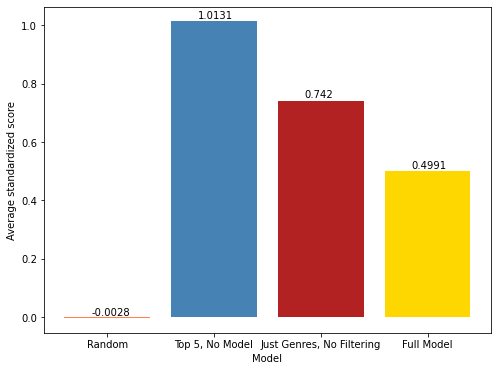

In [49]:
x = ['Random','Top 5, No Model', 'Just Genres, No Filtering', 'Full Model']
y = [-0.0028,1.0131,0.7420,0.4991]
x_pos = np.arange(len(x))
fig = plt.bar(x_pos,y,color=['coral','steelblue','firebrick','gold'])
for index, value in enumerate(y):
    plt.text(index-0.15,value+0.01,s=str(value))
plt.rcParams["figure.figsize"] = (8,6)
plt.xticks(x_pos, x)
plt.xlabel('Model')
plt.ylabel('Average standardized score')
plt.show()

When it comes to coverage, the full model vastly outperforms t5he top 5 models, which is very important for practical applications, as explained earlier.

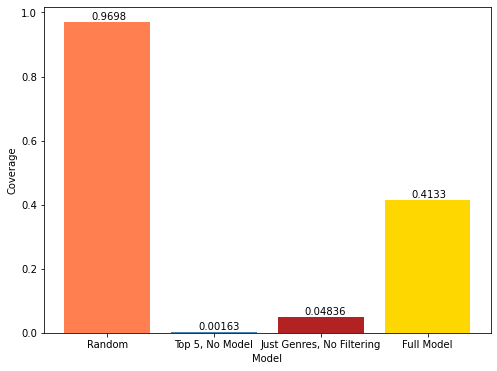

In [50]:
x = ['Random','Top 5, No Model', 'Just Genres, No Filtering', 'Full Model']
y = [0.9698,0.00163,0.04836,0.4133]
x_pos = np.arange(len(x))
fig = plt.bar(x_pos,y,color=['coral','steelblue','firebrick','gold'])
for index, value in enumerate(y):
    plt.text(index-0.15,value+0.01,s=str(value))
plt.rcParams["figure.figsize"] = (8,6)
plt.xticks(x_pos, x)
plt.xlabel('Model')
plt.ylabel('Coverage')
plt.show()

Of the non-random models, the full model is the most performant when it comes to personalization too, outperforming the top 5 among genre clusters model and vastly outperforming the overall top 5 model.

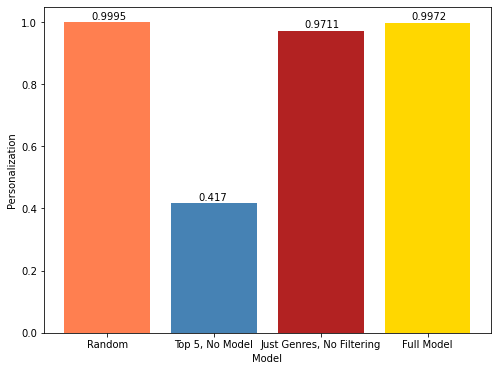

In [51]:
x = ['Random','Top 5, No Model', 'Just Genres, No Filtering', 'Full Model']
y = [0.9995,0.4170,0.9711,0.9972]
x_pos = np.arange(len(x))
fig = plt.bar(x_pos,y,color=['coral','steelblue','firebrick','gold'])
for index, value in enumerate(y):
    plt.text(index-0.15,value+0.01,s=str(value))
plt.rcParams["figure.figsize"] = (8,6)
plt.xticks(x_pos, x)
plt.xlabel('Model')
plt.ylabel('Personalization')
plt.show()

The conclusion to draw is that recommendation is a trade off between the overall user score, and the other factors (voerage and personalization).

This makes sense intuitively. Most people love The Shawshank Redemption and Forrest Gump, so if these two movies were consistently recommended, they'd receive high feedback under the condition that people hadn't already seen them. The problem is that many people already have seen these movies, in addition to other extremely popular movies. A recommender that personalizes choices to the extent that a large part of the available catalog is covered is much more desirable when it comes to giving practical recommendations that will inspire a new user to subscribe to a particular steaming service.

Finally, I will generate some more recommendations for popular movies, in order to show the model in action.

Now that I have constructed the matrix of recommendations, all I need to do is access the relevant row of the matrix to find them, an extremely fast process. The current list of movies could be periodically updated with new releases, and reviews could be scraped from IMDb simultaneously, so that the model stays current.

IMDb is a large and popular website, so there is no issue in relying on it for repeated data acquisition.

In [7]:
#matrix_random = pd.read_csv('personalization_matrix_random.csv')
#matrix_top5 = pd.read_csv('personalization_matrix_top_5.csv')
#matrix_no_words = pd.read_csv('personalization_matrix_no_words.csv')
matrix_full_model = pd.read_csv('personalization.csv',index_col=0)

First, I will check the recommendations for the classic war movie Platoon.

In [76]:
moviename = "platoon"
moviename = moviename.lower()
movie_id = title_id.index[title_id['title'] == moviename].values[0]

movies = matrix_full_model.loc[movie_id,:]
print(movies[movies == 1])

214     1.0
1222    1.0
1242    1.0
1299    1.0
2028    1.0
Name: 1090, dtype: float64


Four of the recommendations are classic movies with military themes, similar to Platoon. The movie "Before The Rain" is a highly acclaimed Macedonian drama movie, which evidently has some overlapping themes with Platoon despite being different on the surface. This is an example of why a more personalized selection is valuable; it's unlikely that most American viewers will have seen this movie, but based on its critical response, it would be a very enjoyable watch.

In [77]:
print(movielens_movies[movielens_movies.index.isin(movies[movies == 1].index)]['title'])

movieId
214         Before the Rain
1222      Full Metal Jacket
1242                  Glory
1299     The Killing Fields
2028    Saving Private Ryan
Name: title, dtype: object


Now, I will show the recommendations for the classic Coen brothers movie No Country For Old Men.

In [20]:
moviename = "no country for old men"
moviename = moviename.lower()
movie_id = title_id.index[title_id['title'] == moviename].values[0]

movies = matrix_full_model.loc[movie_id,:]
print(movies[movies == 1])
print(movielens_movies[movielens_movies.index.isin(movies[movies == 1].index)]['title'])

27866     1.0
32025     1.0
34271     1.0
41863     1.0
174727    1.0
Name: 55820, dtype: float64
movieId
27866                          In My Father's Den
32025                               Walk on Water
34271                               Hustle & Flow
41863     The Three Burials of Melquiades Estrada
174727                                  Good Time
Name: title, dtype: object


Most of the movies here are lesser known. Personally, I have watched The Three Burials of Melquiedes Estrada, and Good Time. The former is a drama with elements of crime in a western setting, similar to No Country, and also stars Tommy Lee Jones. The latter is in an urban setting, but also contains the mix of crime and drama that characterizes No Country. I am not familiar with the other movies, but a cursory look indicates that they are all dramas with mystery or crime/thriller elements, and are all highly regarded by critics. This again indicates the value of drawing from a wide base. It's highly likely the someone who enjoyed No Country For Old Men wouldn't have seen all of these movies, and that they would enjoy at least some of them.

In conclusion, I believe that the results indicate that my model performs well, finding a comfortable middle ground between average user ratings, coverage, and personalization.

In addition to updating the model with more recent movies, other developments of the model could take into account additional information scraped from IMDb, such as the director and principal actors, since many people often consistently enjoy work/performances from the same people.